In [1]:
import xml.etree.ElementTree as ET 
import gzip
from xml.etree.cElementTree import ElementTree

import pandas as pd
import geopandas as gpd
import timeit
import geopy.distance
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from shapely.geometry import Point, MultiPoint, Polygon
import random
from pyproj import Proj, transform #Convertion EPSG2154 to WGS84

from datetime import datetime

import statistics
from collections import defaultdict 

import matsim

In [2]:
def convert_time(x):
    return np.dot(np.array(x.split(":"), dtype = float), [3600.0, 60.0])

def convert_time_h_m_s(x):
    return np.dot(np.array(x.split(":"), dtype = float), [3600.0, 60.0, 1.0])

In [3]:
output_base_path = "/media/aodiallo/Data/MATSIM/Simulation/base_eqasim/simulation_output_1000_ite" 
#output_sc1_path = "/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/scenario1"
output_sc1_path = "/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/scenario1_1000_ite"
#output_sc2_path = "/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/scenario2"
output_sc2_path = "/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/scenario2_v2_15_p_cent_2000_ite"
output_sc3_path = "/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/scenario3_v2_15_p_cent_2000_ite" 

## Ite0

In [4]:
df_trips_output_it0_base = pd.read_csv(gzip.open("%s/ITERS/it.0/0.trips.csv.gz" %output_base_path,'r'), sep=";")
df_trips_output_it0_sc1 = pd.read_csv(gzip.open("/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/scenario1_c3/ITERS/it.0/sce1.tst1.0.trips.csv.gz",'r'), sep=";")
df_trips_output_it0_sc2 = pd.read_csv(gzip.open("%s/ITERS/it.0/sce2.v2.0.trips.csv.gz" %output_sc2_path,'r'), sep=";")
df_trips_output_it0_sc3 = pd.read_csv(gzip.open("%s/ITERS/it.0/sce3.v2.0.trips.csv.gz" %output_sc3_path,'r'), sep=";")

In [5]:
print(len(df_trips_output_it0_base), len(df_trips_output_it0_sc1), len(df_trips_output_it0_sc2), len(df_trips_output_it0_sc3))

228246 217509 227759 228658


## Output trips cvs analysis

In [6]:
df_trips_output_base = pd.read_csv(gzip.open("%s/output_trips.csv.gz" %output_base_path,'r'), sep=";")
df_trips_output_sc1 = pd.read_csv(gzip.open("%s/sce1.1000_ite.output_trips.csv.gz" %output_sc1_path,'r'), sep=";")
df_trips_output_sc2 = pd.read_csv(gzip.open("%s/sce2.v2.output_trips.csv.gz" %output_sc2_path,'r'), sep=";")
df_trips_output_sc3 = pd.read_csv(gzip.open("%s/sce3.v2.output_trips.csv.gz" %output_sc3_path,'r'), sep=";")

In [7]:
df_trips_output_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230359 entries, 0 to 230358
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   person                  230359 non-null  int64  
 1   trip_number             230359 non-null  int64  
 2   trip_id                 230359 non-null  object 
 3   dep_time                230359 non-null  object 
 4   trav_time               230359 non-null  object 
 5   wait_time               230359 non-null  object 
 6   traveled_distance       230359 non-null  int64  
 7   euclidean_distance      230359 non-null  int64  
 8   main_mode               0 non-null       float64
 9   longest_distance_mode   223690 non-null  object 
 10  modes                   230359 non-null  object 
 11  start_activity_type     230359 non-null  object 
 12  end_activity_type       230359 non-null  object 
 13  start_facility_id       230359 non-null  object 
 14  start_link          

In [8]:
df_trips_output_base

,person,trip_number,trip_id,dep_time,trav_time,wait_time,traveled_distance,euclidean_distance,main_mode,longest_distance_mode,...,start_facility_id,start_link,start_x,start_y,end_facility_id,end_link,end_x,end_y,first_pt_boarding_stop,last_pt_egress_stop
0,1000008,1,1000008_1,07:03:47,00:19:35,00:00:00,4528,2193,NaN,car,...,home_474430,8102,844783.995555,6.519932e+06,sec_27677,50655,842728.100000,6.519167e+06,NaN,NaN
1,1000008,2,1000008_2,07:23:22,00:14:29,00:00:00,9621,7331,NaN,car,...,sec_27677,50655,842728.100000,6.519167e+06,work_263614,51370,841768.160000,6.511899e+06,NaN,NaN
2,1000008,3,1000008_3,12:03:47,00:10:16,00:00:00,740,569,NaN,walk,...,work_263614,51370,841768.160000,6.511899e+06,sec_45586,32552,841455.790000,6.511423e+06,NaN,NaN
3,1000008,4,1000008_4,12:33:47,00:10:16,00:00:00,740,569,NaN,walk,...,sec_45586,32552,841455.790000,6.511423e+06,work_263614,51370,841768.160000,6.511899e+06,NaN,NaN
4,1000008,5,1000008_5,17:33:47,00:40:29,00:00:00,12977,8580,NaN,car,...,work_263614,51370,841768.160000,6.511899e+06,home_474430,8102,844783.995555,6.519932e+06,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230354,999994,2,999994_2,07:05:31,00:05:33,00:00:00,1358,802,NaN,car,...,sec_42480,69858,847968.600000,6.518541e+06,edu_1135,33122,847319.700000,6.519014e+06,NaN,NaN
230355,999994,3,999994_3,16:15:31,00:18:33,00:00:00,15563,7480,NaN,car,...,edu_1135,33122,847319.700000,6.519014e+06,home_474420,17018,854492.550000,6.521136e+06,NaN,NaN
230356,999995,1,999995_1,07:13:37,00:13:05,00:00:00,3605,2768,NaN,car,...,home_474420,17018,854492.550000,6.521136e+06,edu_1164,44221,857259.400000,6.521244e+06,NaN,NaN
230357,999995,2,999995_2,11:28:37,00:10:46,00:00:00,3719,2768,NaN,car,...,edu_1164,44221,857259.400000,6.521244e+06,home_474420,17018,854492.550000,6.521136e+06,NaN,NaN


In [9]:
df_trips_output_sc2[df_trips_output_sc2["longest_distance_mode"] == "taxi"]

,person,trip_number,trip_id,dep_time,trav_time,wait_time,traveled_distance,euclidean_distance,main_mode,longest_distance_mode,...,start_facility_id,start_link,start_x,start_y,end_facility_id,end_link,end_x,end_y,first_pt_boarding_stop,last_pt_egress_stop
9,1000009,3,1000009_3,20:24:38,00:06:46,00:00:22,1304,556,NaN,taxi,...,home_474430,8102,844783.995555,6.519932e+06,sec_17516,18634,844413.600000,6.520347e+06,NaN,NaN
10,1000009,4,1000009_4,20:31:24,00:05:17,00:00:34,1190,556,NaN,taxi,...,sec_17516,18634,844413.600000,6.520347e+06,home_474430,8102,844783.995555,6.519932e+06,NaN,NaN
11,1000010,1,1000010_1,07:41:45,01:03:19,00:43:05,3195,2522,NaN,taxi,...,home_474430,8102,844783.995555,6.519932e+06,sec_22644,15949,847012.540000,6.518749e+06,NaN,NaN
12,1000010,2,1000010_2,08:45:04,00:20:58,00:00:02,3510,2522,NaN,taxi,...,sec_22644,15949,847012.540000,6.518749e+06,home_474430,8102,844783.995555,6.519932e+06,NaN,NaN
13,1000010,3,1000010_3,09:06:02,00:10:33,00:02:50,559,322,NaN,taxi,...,home_474430,8102,844783.995555,6.519932e+06,sec_26273,39664,844906.620000,6.520230e+06,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230956,999624,2,999624_2,19:36:56,00:16:23,00:04:10,2588,1528,NaN,taxi,...,sec_11644,52902,851333.720000,6.521767e+06,home_474216,22371,849876.617760,6.522228e+06,NaN,NaN
230976,999871,1,999871_1,08:55:42,00:33:38,00:15:59,4189,2658,NaN,taxi,...,home_474345,73761,846557.250000,6.516266e+06,work_153947,27146,844019.770000,6.517061e+06,NaN,NaN
230977,999871,2,999871_2,17:23:31,00:27:35,00:02:50,4689,2658,NaN,taxi,...,work_153947,27146,844019.770000,6.517061e+06,home_474345,73761,846557.250000,6.516266e+06,NaN,NaN
230987,999946,3,999946_3,14:43:07,00:13:16,00:01:48,2507,1860,NaN,taxi,...,home_474396,10756,841071.050000,6.519148e+06,sec_9767,23235,839282.900000,6.518634e+06,NaN,NaN


In [10]:
0.52333*60

31.3998

In [11]:
print(len(df_trips_output_base), len(df_trips_output_sc1), len(df_trips_output_sc2), len(df_trips_output_sc3))

230359 230272 231001 231000


In [12]:
df_trips_output_base["mode_base"] = df_trips_output_base["longest_distance_mode"]
df_trips_output_sc1["mode_sc1"] = df_trips_output_sc1["longest_distance_mode"]
df_trips_output_sc2["mode_sc2"] = df_trips_output_sc2["longest_distance_mode"]
df_trips_output_sc3["mode_sc3"] = df_trips_output_sc3["longest_distance_mode"]

In [13]:
df_trips_output_it0_base["mode_base"] = df_trips_output_base["longest_distance_mode"]
df_trips_output_it0_sc1["mode_sc1"] = df_trips_output_it0_sc1["longest_distance_mode"]
df_trips_output_it0_sc2["mode_sc2"] = df_trips_output_it0_sc2["longest_distance_mode"]
df_trips_output_it0_sc3["mode_sc3"] = df_trips_output_it0_sc3["longest_distance_mode"]

In [14]:
df_trips_output_base["dep_time_in_s"] = df_trips_output_base["dep_time"].apply(convert_time_h_m_s).astype(float)
df_trips_output_base["trav_time_in_s"] = df_trips_output_base["trav_time"].apply(convert_time_h_m_s).astype(float)
df_trips_output_base["wait_time_in_s"] = df_trips_output_base["wait_time"].apply(convert_time_h_m_s).astype(float)
df_trips_output_sc1["dep_time_in_s"] = df_trips_output_sc1["dep_time"].apply(convert_time_h_m_s).astype(float)
df_trips_output_sc1["trav_time_in_s"] = df_trips_output_sc1["trav_time"].apply(convert_time_h_m_s).astype(float)
df_trips_output_sc1["wait_time_in_s"] = df_trips_output_sc1["wait_time"].apply(convert_time_h_m_s).astype(float)
df_trips_output_sc2["dep_time_in_s"] = df_trips_output_sc2["dep_time"].apply(convert_time_h_m_s).astype(float)
df_trips_output_sc2["trav_time_in_s"] = df_trips_output_sc2["trav_time"].apply(convert_time_h_m_s).astype(float)
df_trips_output_sc2["wait_time_in_s"] = df_trips_output_sc2["wait_time"].apply(convert_time_h_m_s).astype(float)
df_trips_output_sc3["dep_time_in_s"] = df_trips_output_sc3["dep_time"].apply(convert_time_h_m_s).astype(float)
df_trips_output_sc3["trav_time_in_s"] = df_trips_output_sc3["trav_time"].apply(convert_time_h_m_s).astype(float)
df_trips_output_sc3["wait_time_in_s"] = df_trips_output_sc3["wait_time"].apply(convert_time_h_m_s).astype(float)

In [15]:
df_trips_output_sc1.loc[df_trips_output_sc1["mode_sc1"] == "private_AV", "mode_sc1"] = "pav"
df_trips_output_sc2.loc[df_trips_output_sc2["mode_sc2"] == "taxi", "mode_sc2"] = "sav"
df_trips_output_sc3.loc[df_trips_output_sc3["mode_sc3"] == "drt", "mode_sc3"] = "psav"

# Conséquences de l'intoduction des VA sur les comportements de déplacement

### Parts modales

In [16]:
df_trips_global = pd.merge(df_trips_output_base[["person", "trip_id", "mode_base", "dep_time_in_s", "trav_time_in_s", "wait_time_in_s"]], df_trips_output_sc1[["person", "trip_id", "mode_sc1" , "dep_time_in_s", "trav_time_in_s", "wait_time_in_s"]], on=["person","trip_id"], suffixes=('_base', '_sc1'))

In [17]:
df_trips_global

,person,trip_id,mode_base,dep_time_in_s_base,trav_time_in_s_base,wait_time_in_s_base,mode_sc1,dep_time_in_s_sc1,trav_time_in_s_sc1,wait_time_in_s_sc1
0,1000008,1000008_1,car,25427.0,1175.0,0.0,pav,25152.0,747.0,19.0
1,1000008,1000008_2,car,26602.0,869.0,0.0,pav,26302.0,811.0,9.0
2,1000008,1000008_3,walk,43427.0,616.0,0.0,walk,43582.0,616.0,0.0
3,1000008,1000008_4,walk,45227.0,616.0,0.0,walk,44995.0,616.0,0.0
4,1000008,1000008_5,car,63227.0,2429.0,0.0,pav,62554.0,6797.0,3855.0
...,...,...,...,...,...,...,...,...,...,...
229624,999994,999994_2,car,25531.0,333.0,0.0,pav,25852.0,350.0,9.0
229625,999994,999994_3,car,58531.0,1113.0,0.0,pav,58531.0,4019.0,1365.0
229626,999995,999995_1,car,26017.0,785.0,0.0,pav,26017.0,2104.0,1522.0
229627,999995,999995_2,car,41317.0,646.0,0.0,pav,41317.0,565.0,24.0


In [18]:
df_trips_global = pd.merge(df_trips_global, df_trips_output_sc2[["person", "trip_id", "mode_sc2", "dep_time_in_s", "trav_time_in_s", "wait_time_in_s"]], on=["person","trip_id"], suffixes=('', 'sc2'))
df_trips_global = pd.merge(df_trips_global, df_trips_output_sc3[["person", "trip_id", "mode_sc3", "dep_time_in_s", "trav_time_in_s", "wait_time_in_s"]], on=["person","trip_id"], suffixes=('_sc2', '_sc3'))
df_trips_global

,person,trip_id,mode_base,dep_time_in_s_base,trav_time_in_s_base,wait_time_in_s_base,mode_sc1,dep_time_in_s_sc1,trav_time_in_s_sc1,wait_time_in_s_sc1,mode_sc2,dep_time_in_s_sc2,trav_time_in_s_sc2,wait_time_in_s_sc2,mode_sc3,dep_time_in_s_sc3,trav_time_in_s_sc3,wait_time_in_s_sc3
0,1000008,1000008_1,car,25427.0,1175.0,0.0,pav,25152.0,747.0,19.0,pt,25427.0,1464.0,309.0,pt,25427.0,1464.0,309.0
1,1000008,1000008_2,car,26602.0,869.0,0.0,pav,26302.0,811.0,9.0,pt,26891.0,1795.0,112.0,pt,26891.0,1795.0,112.0
2,1000008,1000008_3,walk,43427.0,616.0,0.0,walk,43582.0,616.0,0.0,walk,43427.0,616.0,0.0,walk,43427.0,616.0,0.0
3,1000008,1000008_4,walk,45227.0,616.0,0.0,walk,44995.0,616.0,0.0,walk,45227.0,616.0,0.0,walk,45227.0,616.0,0.0
4,1000008,1000008_5,car,63227.0,2429.0,0.0,pav,62554.0,6797.0,3855.0,pt,63227.0,2938.0,850.0,pt,63227.0,2938.0,841.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229619,999994,999994_2,car,25531.0,333.0,0.0,pav,25852.0,350.0,9.0,car,25342.0,375.0,0.0,car,26024.0,205.0,0.0
229620,999994,999994_3,car,58531.0,1113.0,0.0,pav,58531.0,4019.0,1365.0,car,60019.0,1731.0,0.0,car,62195.0,1206.0,0.0
229621,999995,999995_1,car,26017.0,785.0,0.0,pav,26017.0,2104.0,1522.0,car,25158.0,565.0,0.0,car,27202.0,523.0,0.0
229622,999995,999995_2,car,41317.0,646.0,0.0,pav,41317.0,565.0,24.0,car,38547.0,476.0,0.0,car,41907.0,576.0,0.0


In [19]:
output_results = "/media/aodiallo/Data/MATSIM/Simulation/output/robotaxi_output_trb"

In [20]:
df_trips_global.to_csv("%s/df_trips_global.csv" %output_results)

In [21]:
df_trips_global_it0 = pd.merge(df_trips_output_it0_base[["person", "trip_id", "mode_base"]], df_trips_output_it0_sc1[["person", "trip_id", "mode_sc1"]], on=["person","trip_id"])
df_trips_global_it0 = pd.merge(df_trips_global_it0, df_trips_output_it0_sc2[["person", "trip_id", "mode_sc2"]], on=["person","trip_id"])
df_trips_global_it0 = pd.merge(df_trips_global_it0, df_trips_output_it0_sc3[["person", "trip_id", "mode_sc3"]], on=["person","trip_id"])

In [22]:
df_trips_global_it0.to_csv("%s/df_trips_global_it0.csv" %output_results)

In [23]:
#df_trips_global[["mode_base", "mode_sc1", "mode_sc2", "mode_sc3"]].value_counts(normalize=True) * 100

In [24]:
df_trips_global_it0["mode_base"].value_counts(normalize=True) * 100

car              40.105399
walk             33.836535
pt               16.163944
car_passenger     9.009725
bike              0.884396
Name: mode_base, dtype: float64

In [25]:
df_trips_global_it0

,person,trip_id,mode_base,mode_sc1,mode_sc2,mode_sc3
0,1000008,1000008_1,car,private_AV,taxi,drt
1,1000008,1000008_2,car,private_AV,taxi,drt
2,1000008,1000008_3,walk,walk,walk,walk
3,1000008,1000008_4,walk,walk,walk,walk
4,1000008,1000008_5,car,private_AV,taxi,drt
...,...,...,...,...,...,...
214913,999994,999994_2,car,private_AV,car,car
214914,999994,999994_3,car,private_AV,car,car
214915,999995,999995_1,pt,private_AV,car,car
214916,999995,999995_2,pt,private_AV,car,car


In [26]:
df_trips_global["mode_base"].value_counts(normalize=True) * 100

car              40.111233
walk             33.805028
pt               16.197439
car_passenger     8.993743
bike              0.892557
Name: mode_base, dtype: float64

In [27]:
df_trips_global_it0["mode_sc1"].value_counts(normalize=True) * 100

walk          48.813966
private_AV    31.152346
pt            17.775617
bike           2.258071
Name: mode_sc1, dtype: float64

In [28]:
df_trips_global["mode_sc1"].value_counts(normalize=True) * 100

pav     45.113316
walk    31.074278
pt      23.528464
bike     0.283942
Name: mode_sc1, dtype: float64

In [29]:
df_trips_global_it0["mode_sc2"].value_counts(normalize=True) * 100

walk             46.506575
pt               17.775617
car              14.354777
taxi             13.508873
car_passenger     5.596088
bike              2.258071
Name: mode_sc2, dtype: float64

In [30]:
df_trips_global["mode_sc2"].value_counts(normalize=True) * 100

car              25.160262
pt               23.358186
walk             23.312459
sav              22.643539
car_passenger     5.243790
bike              0.281765
Name: mode_sc2, dtype: float64

In [31]:
df_trips_global_it0["mode_sc3"].value_counts(normalize=True) * 100

walk             46.454462
pt               17.844946
car              14.354777
drt              13.491657
car_passenger     5.596088
bike              2.258071
Name: mode_sc3, dtype: float64

In [32]:
df_trips_global["mode_sc3"].value_counts(normalize=True) * 100

car              26.257273
pt               25.200763
walk             24.056719
psav             18.992353
car_passenger     5.214612
bike              0.278281
Name: mode_sc3, dtype: float64

In [33]:
list_values=[]
for col in ['mode_base','mode_sc1','mode_sc2','mode_sc3']:
    list_values+=(df_trips_global[col].unique().tolist())
list_values=set(list_values)

In [34]:
cross_tab_prop=pd.DataFrame(columns=list_values)
for col in ['mode_base','mode_sc1','mode_sc2','mode_sc3']:
    cross_tab = (100* df_trips_global.groupby(by=[col]).count() / df_trips_global.shape[0]).rename(columns={'person':'%_'+str(col)})[['%_'+str(col)]]
    cross_tab.index.name=None
    cross_tab=cross_tab.transpose()#.loc['bike'].values[0]
    cross_tab_prop=cross_tab_prop.append(cross_tab)
cross_tab_prop=cross_tab_prop.fillna(0)
cross_tab_prop

/tmp/ipykernel_310441/2036488111.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cross_tab_prop=cross_tab_prop.append(cross_tab)
/tmp/ipykernel_310441/2036488111.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cross_tab_prop=cross_tab_prop.append(cross_tab)
/tmp/ipykernel_310441/2036488111.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cross_tab_prop=cross_tab_prop.append(cross_tab)
/tmp/ipykernel_310441/2036488111.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cross_tab_prop=cross_tab_prop.append(cross_tab)


,car,NaN,sav,pav,psav,car_passenger,bike,pt,walk
%_mode_base,38.946277,0,0.000000,0.000000,0.000000,8.732537,0.866634,15.727015,32.823224
%_mode_sc1,0.000000,0,0.000000,45.113316,0.000000,0.000000,0.283942,23.528464,31.074278
%_mode_sc2,25.160262,0,22.643539,0.000000,0.000000,5.243790,0.281765,23.358186,23.312459
%_mode_sc3,26.257273,0,0.000000,0.000000,18.992353,5.214612,0.278281,25.200763,24.056719


In [35]:
x=['mode_base','mode_sc1','mode_sc2','mode_sc3']

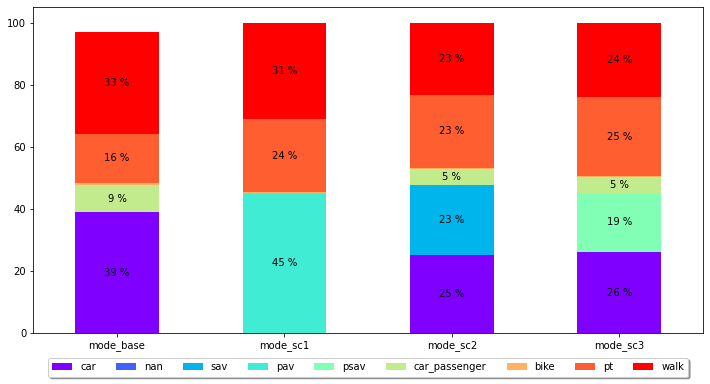

In [36]:
ax=cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='rainbow', 
                    figsize=(10, 6))

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height>2:# pourcentage que pour les valeurs +2%
        ax.text(x+width/2, 
                y+height/2, 
                '{:.0f} %'.format(height), 
                horizontalalignment='center', 
                verticalalignment='center')
        
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06),
          fancybox=True, shadow=True, ncol=10)

xlabels=['mode_base','mode_sc1','mode_sc2','mode_sc3']
ax.set_xticklabels(xlabels, rotation=0, rotation_mode="anchor")

# Get current figure
fig = plt.gcf()

# Set size in inches
fig.set_size_inches(12, 6)

# Set the color of the background to white
fig.set_facecolor("w")

#fig.suptitle("mode",y=0.12)

#fig.show()
fig.savefig('%s/graphes/parts_modales_base_sc1_sc2_sc3.pdf' %output_results, bbox_inches="tight")

## Recherche des VP par zones urbaines/périphériques

In [37]:
#output_path_sc2 = "" 
input_trips_file = "%s/df_trips_input_plans_sce2.csv" %output_sc2_path
input_persons_file = "%s/df_persons_input_perons_sce2.csv" %output_sc2_path
df_persons_input_sce2 = pd.read_csv(input_persons_file)
#df_trips_input = pd.read_csv(input_trips_file)

In [38]:
df_persons_input_sce2

,Unnamed: 0,age,bikeAvailability,carAvailability,censusHouseholdId,censusPersonId,employed,hasLicense,hasPtSubscription,householdId,householdIncome,htsHouseholdId,htsPersonId,isPassenger,sex,subpopulation,person_id
0,0,32,none,none,183012,377986,True,yes,False,474430,4476.391583,8484,18514,False,m,urban_motorized,1000008
1,1,32,all,none,183012,377986,True,yes,False,474430,4476.391583,1537,3356,False,m,urban_motorized,1000009
2,2,32,some,none,183012,377986,True,yes,False,474430,4476.391583,4923,10846,True,m,urban_motorized,1000010
3,3,33,none,none,18480,38075,False,yes,True,47644,2083.709401,8999,19603,False,m,peripheral_motorized,100002
4,4,33,all,none,18480,38075,False,yes,False,47644,2083.709401,1830,3991,False,m,peripheral_motorized,100003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63165,63165,66,none,none,182997,377959,True,yes,False,474396,3022.192917,680,1540,False,f,urban_motorized,999947
63166,63166,25,none,none,183008,377980,False,yes,False,474420,4924.560292,535,1230,False,m,peripheral_motorized,999992
63167,63167,25,none,none,183008,377980,False,no,True,474420,4924.560292,7535,16468,False,m,peripheral_motorized,999993
63168,63168,23,none,none,183008,377981,False,yes,False,474420,4924.560292,3375,7270,False,f,peripheral_motorized,999994


In [39]:
df_trips_global_cp = df_trips_global.copy()

In [40]:
df_trips_global["person_id"] = df_trips_global["person"]

In [41]:
df_trips_global_geog = pd.merge(df_trips_global, df_persons_input_sce2[["person_id", "subpopulation"]], on="person_id")

In [42]:
df_trips_global_geog

,person,trip_id,mode_base,dep_time_in_s_base,trav_time_in_s_base,wait_time_in_s_base,mode_sc1,dep_time_in_s_sc1,trav_time_in_s_sc1,wait_time_in_s_sc1,mode_sc2,dep_time_in_s_sc2,trav_time_in_s_sc2,wait_time_in_s_sc2,mode_sc3,dep_time_in_s_sc3,trav_time_in_s_sc3,wait_time_in_s_sc3,person_id,subpopulation
0,1000008,1000008_1,car,25427.0,1175.0,0.0,pav,25152.0,747.0,19.0,pt,25427.0,1464.0,309.0,pt,25427.0,1464.0,309.0,1000008,urban_motorized
1,1000008,1000008_2,car,26602.0,869.0,0.0,pav,26302.0,811.0,9.0,pt,26891.0,1795.0,112.0,pt,26891.0,1795.0,112.0,1000008,urban_motorized
2,1000008,1000008_3,walk,43427.0,616.0,0.0,walk,43582.0,616.0,0.0,walk,43427.0,616.0,0.0,walk,43427.0,616.0,0.0,1000008,urban_motorized
3,1000008,1000008_4,walk,45227.0,616.0,0.0,walk,44995.0,616.0,0.0,walk,45227.0,616.0,0.0,walk,45227.0,616.0,0.0,1000008,urban_motorized
4,1000008,1000008_5,car,63227.0,2429.0,0.0,pav,62554.0,6797.0,3855.0,pt,63227.0,2938.0,850.0,pt,63227.0,2938.0,841.0,1000008,urban_motorized
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229619,999994,999994_2,car,25531.0,333.0,0.0,pav,25852.0,350.0,9.0,car,25342.0,375.0,0.0,car,26024.0,205.0,0.0,999994,peripheral_motorized
229620,999994,999994_3,car,58531.0,1113.0,0.0,pav,58531.0,4019.0,1365.0,car,60019.0,1731.0,0.0,car,62195.0,1206.0,0.0,999994,peripheral_motorized
229621,999995,999995_1,car,26017.0,785.0,0.0,pav,26017.0,2104.0,1522.0,car,25158.0,565.0,0.0,car,27202.0,523.0,0.0,999995,peripheral_motorized
229622,999995,999995_2,car,41317.0,646.0,0.0,pav,41317.0,565.0,24.0,car,38547.0,476.0,0.0,car,41907.0,576.0,0.0,999995,peripheral_motorized


In [43]:
df_trips_global_geog[df_trips_global_geog["subpopulation"] =="urban_motorized"]["mode_base"].unique()

array(['car', 'walk', 'car_passenger', nan, 'pt', 'bike'], dtype=object)

In [44]:
df_trips_global_geog[df_trips_global_geog["subpopulation"] =="peripheral_motorized"]["mode_base"].unique()

array(['walk', 'pt', 'car', nan, 'car_passenger', 'bike'], dtype=object)

In [45]:
df_trips_global_geog[df_trips_global_geog["subpopulation"] =="urban_no_motorized"]["mode_base"].unique()

array(['pt', 'walk', 'car_passenger', nan, 'bike'], dtype=object)

In [46]:
df_trips_global_geog[df_trips_global_geog["subpopulation"] =="peripheral_no_motorized"]["mode_base"].unique()

array(['pt', 'walk', 'car_passenger', nan, 'bike'], dtype=object)

In [47]:
df_trips_global_geog["mode_base_sptl"] = df_trips_global_geog["mode_base"]

In [48]:
##car urban_motorized
f_car_urban_motorized = df_trips_global_geog["subpopulation"]=="urban_motorized"
f_car_urban_motorized &= df_trips_global_geog["mode_base"]=="car"

##car peripheral_motorized
f_car_peripheral_motorized = df_trips_global_geog["subpopulation"]=="peripheral_motorized"
f_car_peripheral_motorized &= df_trips_global_geog["mode_base"]=="car"

In [49]:
## car_passenger urban_motorized and urban_no_motorized
f_car_passenger_urban = (df_trips_global_geog["subpopulation"]=="urban_motorized") | (df_trips_global_geog["subpopulation"]=="urban_no_motorized")
f_car_passenger_urban &= df_trips_global_geog["mode_base"]=="car_passenger"

##car_passenger peripheral_motorized and peripheral_no_motorized
f_car_passenger_peripheral = (df_trips_global_geog["subpopulation"]=="peripheral_motorized") | (df_trips_global_geog["subpopulation"]=="peripheral_no_motorized")
f_car_passenger_peripheral &= df_trips_global_geog["mode_base"]=="car_passenger"

In [50]:
##pt urban_motorized and urban_no_motorized
f_pt_urban = (df_trips_global_geog["subpopulation"]=="urban_motorized") | (df_trips_global_geog["subpopulation"]=="urban_no_motorized")
f_pt_urban &= df_trips_global_geog["mode_base"]=="pt"

##pt peripheral_no_motorized
f_pt_peripheral = (df_trips_global_geog["subpopulation"]=="peripheral_motorized") | (df_trips_global_geog["subpopulation"]=="peripheral_no_motorized")
f_pt_peripheral &= df_trips_global_geog["mode_base"]=="pt"

##walk urban_motorized and urban_no_motorized
f_walk_urban = (df_trips_global_geog["subpopulation"]=="urban_motorized") | (df_trips_global_geog["subpopulation"]=="urban_no_motorized")
f_walk_urban &= df_trips_global_geog["mode_base"]=="walk"

##walk peripheral_motorized and peripheral_no_motorized
f_walk_peripheral = (df_trips_global_geog["subpopulation"]=="peripheral_motorized") | (df_trips_global_geog["subpopulation"]=="peripheral_no_motorized")
f_walk_peripheral &= df_trips_global_geog["mode_base"]=="walk"


##bike urban_motorized and urban_no_motorized
f_bike_urban = (df_trips_global_geog["subpopulation"]=="urban_motorized") | (df_trips_global_geog["subpopulation"]=="urban_no_motorized")
f_bike_urban &= df_trips_global_geog["mode_base"]=="bike"

##bike peripheral_motorized and peripheral_no_motorized
f_bike_peripheral = (df_trips_global_geog["subpopulation"]=="peripheral_motorized") | (df_trips_global_geog["subpopulation"]=="peripheral_no_motorized")
f_bike_peripheral &= df_trips_global_geog["mode_base"]=="bike"

In [51]:
df_trips_global_geog.loc[f_car_urban_motorized, "mode_base_sptl"] = "car_urban"
df_trips_global_geog.loc[f_car_peripheral_motorized, "mode_base_sptl"] = "car_periph"


df_trips_global_geog.loc[f_car_passenger_urban, "mode_base_sptl"] = "car_passenger_urban"
df_trips_global_geog.loc[f_car_passenger_peripheral, "mode_base_sptl"] = "car_passenger_periph"


df_trips_global_geog.loc[f_pt_urban, "mode_base_sptl"] = "pt_urban"
df_trips_global_geog.loc[f_pt_peripheral, "mode_base_sptl"] = "pt_periph"


df_trips_global_geog.loc[f_walk_urban, "mode_base_sptl"] = "walk_urban"
df_trips_global_geog.loc[f_walk_peripheral, "mode_base_sptl"] = "walk_periph"

df_trips_global_geog.loc[f_bike_urban, "mode_base_sptl"] = "bike_urban"
df_trips_global_geog.loc[f_bike_peripheral, "mode_base_sptl"] = "bike_periph"

In [52]:
df_trips_global_geog

,person,trip_id,mode_base,dep_time_in_s_base,trav_time_in_s_base,wait_time_in_s_base,mode_sc1,dep_time_in_s_sc1,trav_time_in_s_sc1,wait_time_in_s_sc1,...,dep_time_in_s_sc2,trav_time_in_s_sc2,wait_time_in_s_sc2,mode_sc3,dep_time_in_s_sc3,trav_time_in_s_sc3,wait_time_in_s_sc3,person_id,subpopulation,mode_base_sptl
0,1000008,1000008_1,car,25427.0,1175.0,0.0,pav,25152.0,747.0,19.0,...,25427.0,1464.0,309.0,pt,25427.0,1464.0,309.0,1000008,urban_motorized,car_urban
1,1000008,1000008_2,car,26602.0,869.0,0.0,pav,26302.0,811.0,9.0,...,26891.0,1795.0,112.0,pt,26891.0,1795.0,112.0,1000008,urban_motorized,car_urban
2,1000008,1000008_3,walk,43427.0,616.0,0.0,walk,43582.0,616.0,0.0,...,43427.0,616.0,0.0,walk,43427.0,616.0,0.0,1000008,urban_motorized,walk_urban
3,1000008,1000008_4,walk,45227.0,616.0,0.0,walk,44995.0,616.0,0.0,...,45227.0,616.0,0.0,walk,45227.0,616.0,0.0,1000008,urban_motorized,walk_urban
4,1000008,1000008_5,car,63227.0,2429.0,0.0,pav,62554.0,6797.0,3855.0,...,63227.0,2938.0,850.0,pt,63227.0,2938.0,841.0,1000008,urban_motorized,car_urban
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229619,999994,999994_2,car,25531.0,333.0,0.0,pav,25852.0,350.0,9.0,...,25342.0,375.0,0.0,car,26024.0,205.0,0.0,999994,peripheral_motorized,car_periph
229620,999994,999994_3,car,58531.0,1113.0,0.0,pav,58531.0,4019.0,1365.0,...,60019.0,1731.0,0.0,car,62195.0,1206.0,0.0,999994,peripheral_motorized,car_periph
229621,999995,999995_1,car,26017.0,785.0,0.0,pav,26017.0,2104.0,1522.0,...,25158.0,565.0,0.0,car,27202.0,523.0,0.0,999995,peripheral_motorized,car_periph
229622,999995,999995_2,car,41317.0,646.0,0.0,pav,41317.0,565.0,24.0,...,38547.0,476.0,0.0,car,41907.0,576.0,0.0,999995,peripheral_motorized,car_periph


In [53]:
#Thank to Adel for the code
list_values=[]
for col in ['mode_base', 'mode_base_sptl', 'mode_sc1','mode_sc2','mode_sc3']:
    list_values+=(df_trips_global_geog[col].unique().tolist())
list_values=set(list_values)

In [54]:
cross_tab_prop=pd.DataFrame(columns=list_values)
for col in ['mode_base','mode_base_sptl', 'mode_sc1','mode_sc2','mode_sc3']:
    cross_tab = (100* df_trips_global_geog.groupby(by=[col]).count() / df_trips_global_geog.shape[0]).rename(columns={'person':'%_'+str(col)})[['%_'+str(col)]]
    cross_tab.index.name=None
    cross_tab=cross_tab.transpose()#.loc['bike'].values[0]
    cross_tab_prop=cross_tab_prop.append(cross_tab)
cross_tab_prop=cross_tab_prop.fillna(0)
cross_tab_prop

/tmp/ipykernel_310441/1476501995.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cross_tab_prop=cross_tab_prop.append(cross_tab)
/tmp/ipykernel_310441/1476501995.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cross_tab_prop=cross_tab_prop.append(cross_tab)
/tmp/ipykernel_310441/1476501995.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cross_tab_prop=cross_tab_prop.append(cross_tab)
/tmp/ipykernel_310441/1476501995.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cross_tab_prop=cross_tab_prop.append(cross_tab)
/tmp/ipykernel_310441/1476501995.py:6: FutureWarning: The frame.append method is deprecated and will be removed 

,NaN,pt_periph,bike_periph,walk_periph,walk,walk_urban,car,psav,car_periph,bike,car_urban,sav,pt_urban,bike_urban,pav,car_passenger_urban,car_passenger,pt,car_passenger_periph
%_mode_base,0,0.000000,0.000000,0.000000,32.823224,0.00000,38.946277,0.000000,0.000000,0.866634,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.732537,15.727015,0.000000
%_mode_base_sptl,0,4.415044,0.381493,10.487144,0.000000,22.33608,0.000000,0.000000,17.274762,0.000000,21.671515,0.000000,11.311971,0.485141,0.000000,3.905515,0.000000,0.000000,4.827022
%_mode_sc1,0,0.000000,0.000000,0.000000,31.074278,0.00000,0.000000,0.000000,0.000000,0.283942,0.000000,0.000000,0.000000,0.000000,45.113316,0.000000,0.000000,23.528464,0.000000
%_mode_sc2,0,0.000000,0.000000,0.000000,23.312459,0.00000,25.160262,0.000000,0.000000,0.281765,0.000000,22.643539,0.000000,0.000000,0.000000,0.000000,5.243790,23.358186,0.000000
%_mode_sc3,0,0.000000,0.000000,0.000000,24.056719,0.00000,26.257273,18.992353,0.000000,0.278281,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.214612,25.200763,0.000000


In [55]:
x=['mode_base', 'mode_base_sptl', 'mode_sc1','mode_sc2','mode_sc3']

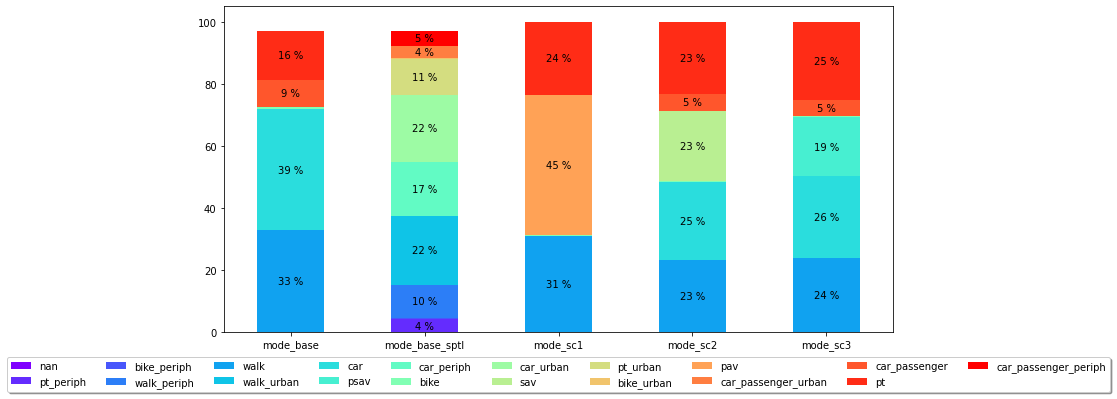

In [56]:
ax=cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='rainbow', 
                    figsize=(10, 6))

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height>2:# pourcentage que pour les valeurs +2%
        ax.text(x+width/2, 
                y+height/2, 
                '{:.0f} %'.format(height), 
                horizontalalignment='center', 
                verticalalignment='center')
        
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06),
          fancybox=True, shadow=True, ncol=10)

xlabels=['mode_base', 'mode_base_sptl', 'mode_sc1','mode_sc2','mode_sc3']
ax.set_xticklabels(xlabels, rotation=0, rotation_mode="anchor")

# Get current figure
fig = plt.gcf()

# Set size in inches
fig.set_size_inches(12, 6)

# Set the color of the background to white
fig.set_facecolor("w")

#fig.suptitle("mode",y=0.12)

#fig.show()
fig.savefig('%s/graphes/parts_modales_base_base-sptl_sc1_sc2_sc3.pdf' %output_results, bbox_inches="tight")

In [57]:
#Thank to Adel for the code
from pySankey.sankey import sankey

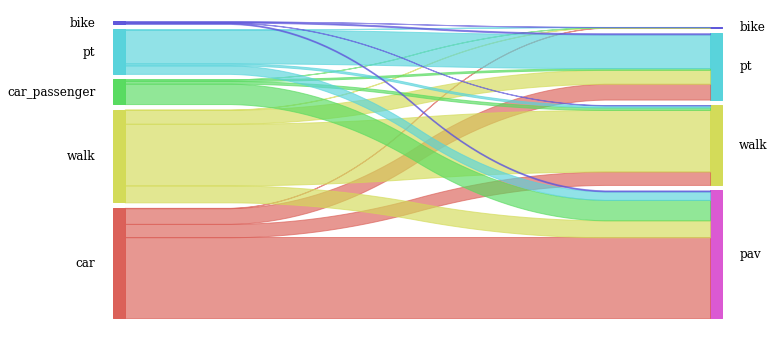

In [58]:
df_trips_global.dropna(inplace=True)#Sankey graph does not support null values.

colors = {
    "val1": "#f71b1b",
    "val2": "#1b7ef7", ## à completer si besoin de choisir les couleurs 
}

sankey(df_trips_global["mode_base"], df_trips_global["mode_sc1"], aspect=20, fontsize=12) # rajouter colorDict=colors pour les couleurs


# Get current figure
fig = plt.gcf()

# Set size in inches
fig.set_size_inches(12, 6)

# Set the color of the background to white
fig.set_facecolor("w")

#fig.suptitle("(a) mode_base -> mode_sc1",y=0.12)

#fig.show()
fig.savefig('%s/graphes/diagram_base-sc1.pdf' %output_results, bbox_inches="tight")

In [59]:
f_car_base = df_trips_global["mode_base"] == "car"
f_car_base |= df_trips_global["mode_base"] == "car_passenger"
f_bike_base = df_trips_global["mode_base"] == "bike"
f_pt_base = df_trips_global["mode_base"] == "pt"
f_walk_base = df_trips_global["mode_base"] == "walk"

In [60]:
f_pav = df_trips_global["mode_sc1"] == "pav"
f_pt_sc1 = df_trips_global["mode_sc1"] == "pt"
f_bike_sc1 = df_trips_global["mode_sc1"] == "bike"
f_walk_sc1 = df_trips_global["mode_sc1"] == "walk"

In [61]:
f_pav_car = f_pav & f_car_base
f_pav_bike = f_pav & f_bike_base
f_pav_pt = f_pav & f_pt_base
f_pav_walk = f_pav & f_walk_base


f_no_pav_car = (~f_pav) & f_car_base

f_pt_sc1_car = f_pt_sc1 & f_car_base
f_bike_sc1_car = f_bike_sc1 & f_car_base
f_walk_sc1_car = f_walk_sc1 & f_car_base

In [297]:
demand_pav_car = len(df_trips_global[f_pav_car]) / len(df_trips_global[f_pav]) * 100
demand_pav_car

79.25495458099641

In [299]:
demand_no_pav_car = len(df_trips_global[f_no_pav_car]) / len(df_trips_global[f_car_base]) * 100
demand_no_pav_car

25.009590617635773

In [64]:
demand_pt_sc1_car = len(df_trips_global[f_pt_sc1_car]) / len(df_trips_global[f_car_base]) * 100
demand_pt_sc1_car

12.960121298478288

In [65]:
demand_bike_sc1_car = len(df_trips_global[f_bike_sc1_car]) / len(df_trips_global[f_car_base]) * 100
demand_bike_sc1_car

0.22469447032388884

In [66]:
demand_walk_sc1_car = len(df_trips_global[f_walk_sc1_car]) / len(df_trips_global[f_car_base]) * 100
demand_walk_sc1_car

11.824774848833599

In [300]:
demand_pav_bike = len(df_trips_global[f_pav_bike]) / len(df_trips_global[f_pav]) * 100
demand_pav_bike

0.7713025262812406

In [301]:
demand_pav_pt = len(df_trips_global[f_pav_pt]) / len(df_trips_global[f_pav]) * 100
demand_pav_pt

6.683013003060112

In [302]:
demand_pav_walk = len(df_trips_global[f_pav_walk]) / len(df_trips_global[f_pav]) * 100
demand_pav_walk

13.290729889662229

In [70]:
#stop

- car->  PT ou walk : utlisation du PAV par d'autres membres de la famille (un PAV par menage)
- vélo/marche -> pav -> attractivité de ce mode
- limite du PAV : pas d'optisation de l'utilisation du PAV entre les differents membres du menages

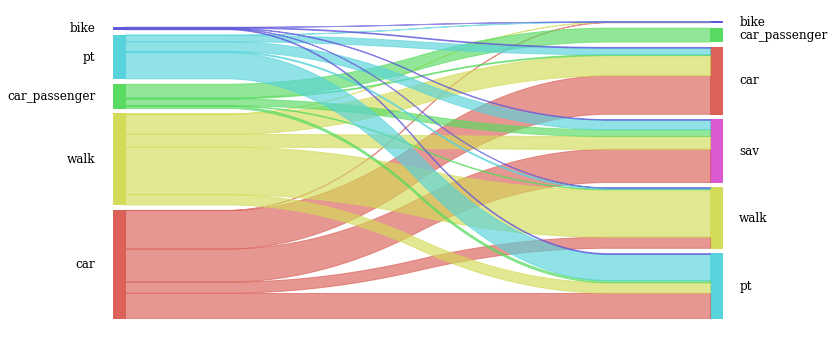

In [71]:
sankey(df_trips_global["mode_base"], df_trips_global["mode_sc2"], aspect=20, fontsize=12) # rajouter colorDict=colors pour les couleurs


# Get current figure
fig = plt.gcf()

# Set size in inches
fig.set_size_inches(12, 6)

# Set the color of the background to white
fig.set_facecolor("w")


#fig.suptitle("(b) mode_base -> mode_sc2",y=0.12)

#fig.show()
fig.savefig('%s/graphes/diagram_base-sc2.pdf' %output_results, bbox_inches="tight")

- car -> pt : taxi pas attractif pour ces individus au regard peut-etre du temps d'attente
- walk/pt -> car : possible attractivité de la VP au regard de la reduction du flux en VP : moins de congestion
- pt -> taxi : possible confrontation des taxi avec les TP. 

=> Reduire la capacité du réseau routie en fonction de la flotte des taxis

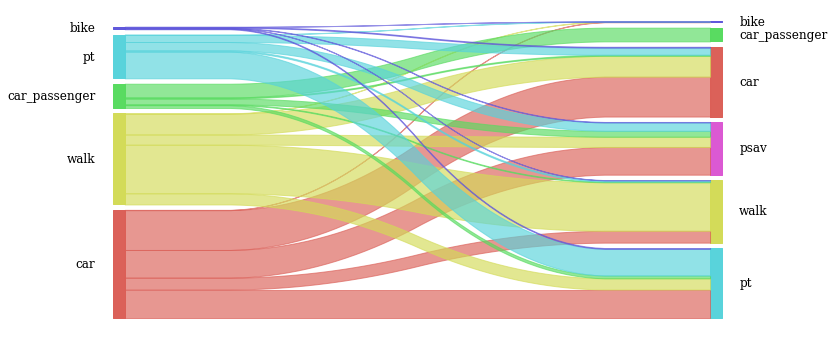

In [72]:
sankey(df_trips_global["mode_base"], df_trips_global["mode_sc3"], aspect=20, fontsize=12) # rajouter colorDict=colors pour les couleurs


# Get current figure
fig = plt.gcf()

# Set size in inches
fig.set_size_inches(12, 6)

# Set the color of the background to white
fig.set_facecolor("w")


#fig.suptitle("(c) mode_base -> mode_sc2",y=0.12)

#fig.show()
fig.savefig('%s/graphes/diagram_base-sc3.pdf' %output_results, bbox_inches="tight")

- drt moins acttractif du au partage de ce mode (selon les parts modales) => temps d'attente, de temps de detour...
- car -> pt : meme effet que pour le taxi

## Prise en compte des infos spatiales

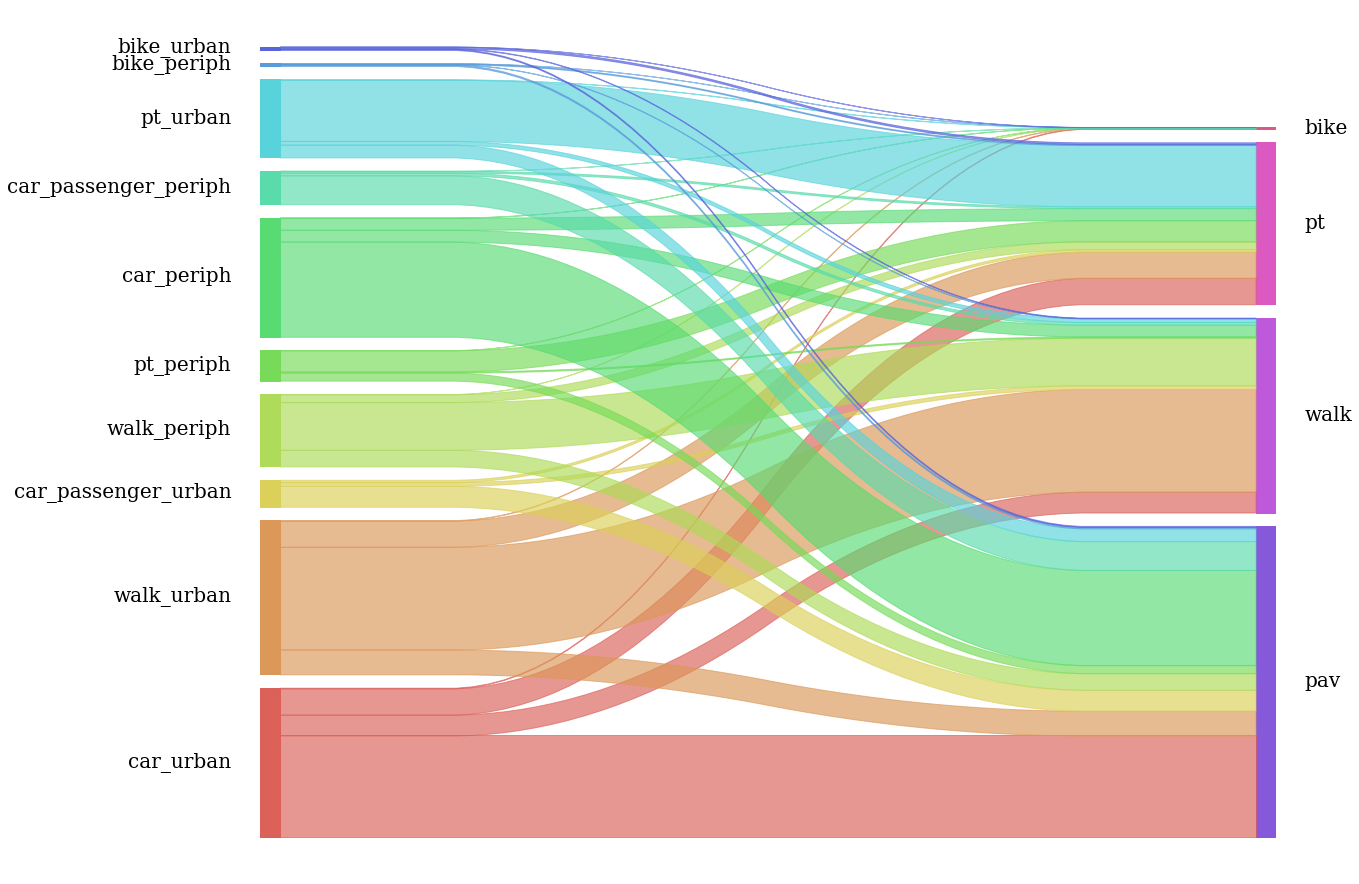

In [73]:
df_trips_global_geog.dropna(inplace=True)#Sankey graph does not support null values.

colors = {
    "val1": "#f71b1b",
    "val2": "#1b7ef7", ## à completer si besoin de choisir les couleurs 
}

sankey(df_trips_global_geog["mode_base_sptl"], df_trips_global_geog["mode_sc1"], aspect=20, fontsize=20) # rajouter colorDict=colors pour les couleurs


# Get current figure
fig = plt.gcf()

# Set size in inches
fig.set_size_inches(20, 16)

# Set the color of the background to white
fig.set_facecolor("w")

#fig.suptitle("(a) mode_base_sptl -> mode_sc1",y=0.12)

#fig.show()
fig.savefig('%s/graphes/diagram_base_sptl-sc1.pdf' %output_results, bbox_inches="tight")

- car->  PT ou walk : utlisation du PAV par d'autres membres de la famille (un PAV par menage)
- vélo/marche -> pav -> attractivité de ce mode
- limite du PAV : pas d'optisation de l'utilisation du PAV entre les differents membres du menages

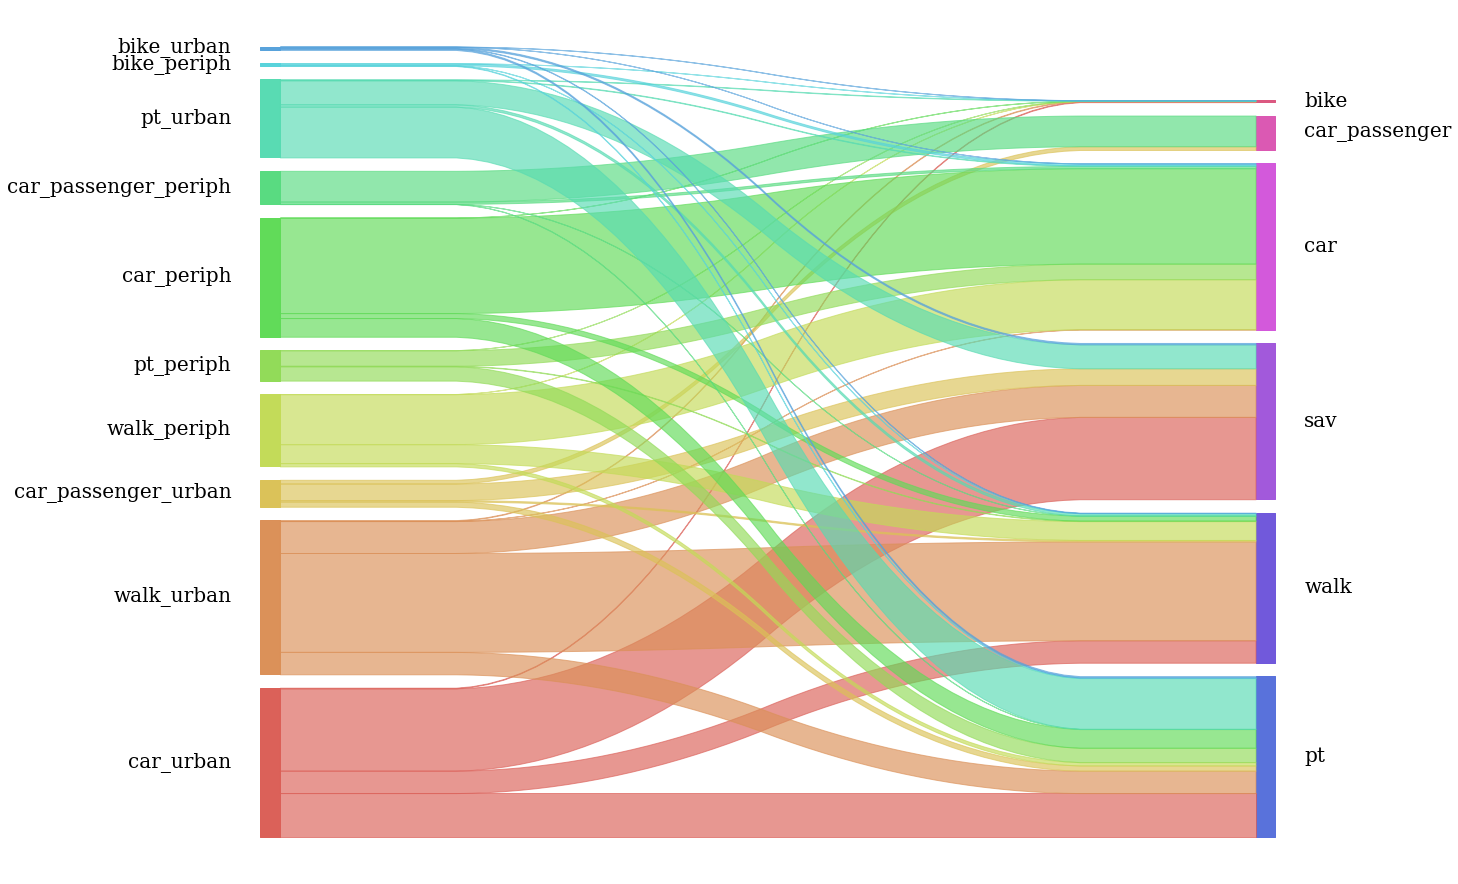

In [74]:
sankey(df_trips_global_geog["mode_base_sptl"], df_trips_global_geog["mode_sc2"], aspect=20, fontsize=20) # rajouter colorDict=colors pour les couleurs


# Get current figure
fig = plt.gcf()

# Set size in inches
fig.set_size_inches(20, 16)

# Set the color of the background to white
fig.set_facecolor("w")


#fig.suptitle("(b) mode_base -> mode_sc2",y=0.12)

#fig.show()
fig.savefig('%s/graphes/diagram_base_sptl-sc2.pdf' %output_results, bbox_inches="tight")

In [75]:
f_car_urban_base = df_trips_global_geog["mode_base_sptl"] == "car_urban"
f_car_urban_base |= df_trips_global_geog["mode_base_sptl"] == "car_passenger_urban"
f_bike_urban_base = df_trips_global_geog["mode_base_sptl"] == "bike_urban"
f_pt_urban_base = df_trips_global_geog["mode_base_sptl"] == "pt_urban"
f_walk_urban_base = df_trips_global_geog["mode_base_sptl"] == "walk_urban"

In [76]:
f_sav = df_trips_global_geog["mode_sc2"] == "sav"
f_pt_sc2 = df_trips_global_geog["mode_sc2"] == "pt"
f_bike_sc2 = df_trips_global_geog["mode_sc2"] == "bike"
f_walk_sc2 = df_trips_global_geog["mode_sc2"] == "walk"

In [77]:
f_sav_car = f_sav & f_car_urban_base
f_sav_bike = f_sav & f_bike_urban_base
f_sav_pt = f_sav & f_pt_urban_base
f_sav_walk = f_sav & f_walk_urban_base

f_pt_sc2_car = f_pt_sc2 & f_car_urban_base
f_bike_sc2_car = f_bike_sc2 & f_car_urban_base
f_walk_sc2_car = f_walk_sc2 & f_car_urban_base

In [78]:
share_car_sav = len(df_trips_global_geog[f_sav_car]) / len(df_trips_global_geog[f_sav]) * 100
share_car_sav

63.31378017117031

In [79]:
share_pt_sav = len(df_trips_global_geog[f_sav_pt]) / len(df_trips_global_geog[f_sav]) * 100
share_pt_sav

15.341859794210983

In [412]:
f_car_pt_sc2 = f_pt_sc2 & f_car_urban_base
share_car_pt_sc2 = len(df_trips_global_geog[f_car_pt_sc2]) / len(df_trips_global_geog[f_pt_sc2]) * 100
share_car_pt_sc2

30.64871115753348

In [413]:
f_car_walk_sc2 = f_walk_sc2 & f_car_urban_base
share_car_walk_sc2 = len(df_trips_global_geog[f_car_walk_sc2]) / len(df_trips_global_geog[f_walk_sc2]) * 100
share_car_walk_sc2

15.897805542207271

- car -> pt : taxi pas attractif pour ces individus au regard peut-etre du temps d'attente
- walk/pt -> car : possible attractivité de la VP au regard de la reduction du flux en VP : moins de congestion
- pt -> taxi : possible confrontation des taxi avec les TP. 

=> Reduire la capacité du réseau routie en fonction de la flotte des taxis

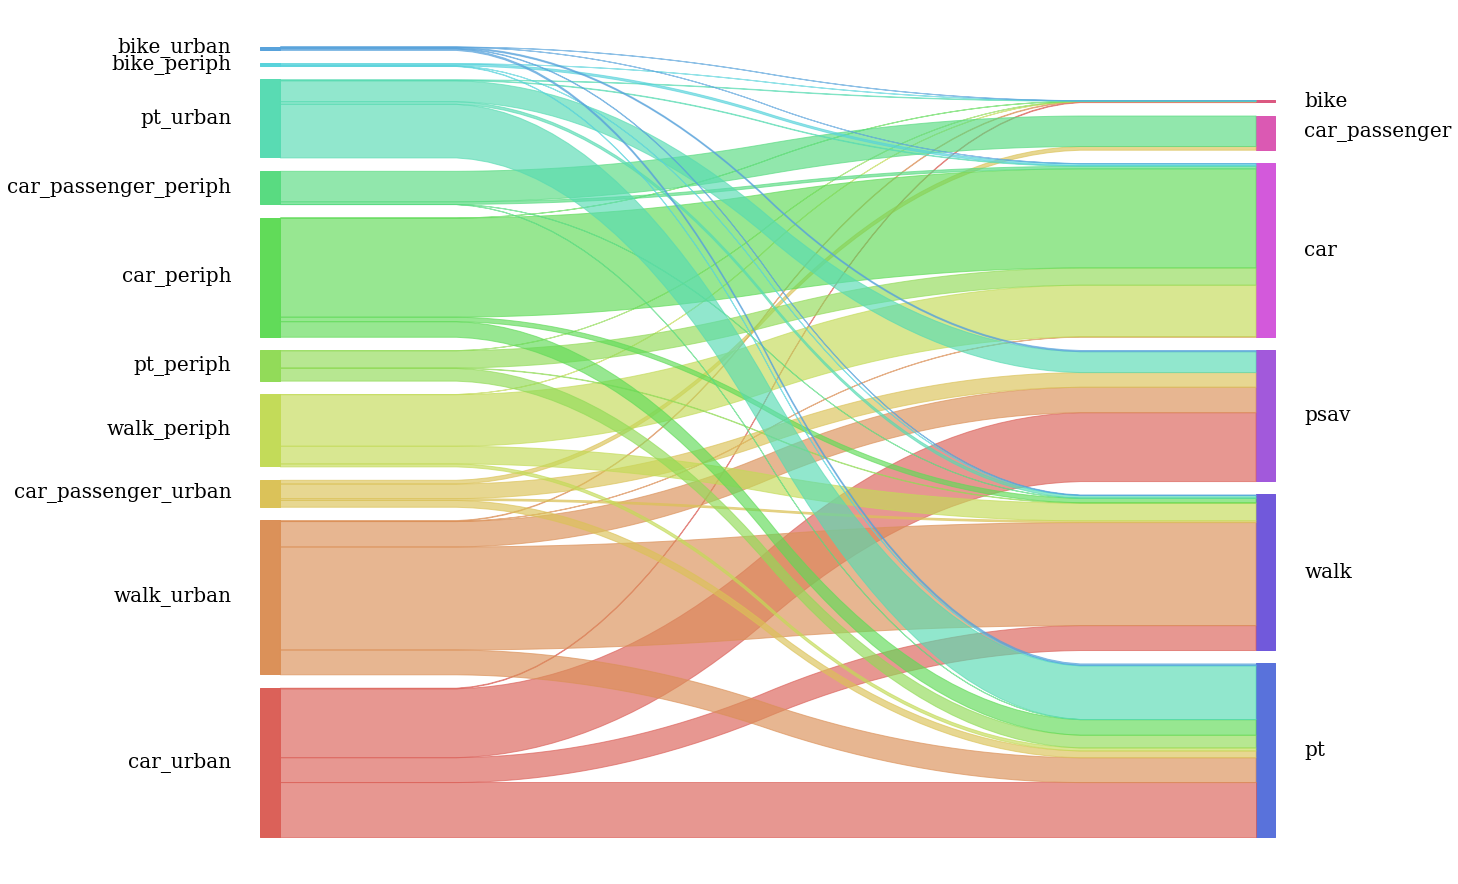

In [80]:
sankey(df_trips_global_geog["mode_base_sptl"], df_trips_global_geog["mode_sc3"], aspect=20, fontsize=20) # rajouter colorDict=colors pour les couleurs


# Get current figure
fig = plt.gcf()

# Set size in inches
fig.set_size_inches(20, 16)

# Set the color of the background to white
fig.set_facecolor("w")


#fig.suptitle("(c) mode_base -> mode_sc2",y=0.12)

#fig.show()
fig.savefig('%s/graphes/diagram_base_sptl-sc3.pdf' %output_results, bbox_inches="tight")

In [81]:
f_psav = df_trips_global_geog["mode_sc3"] == "psav"
f_pt_sc3 = df_trips_global_geog["mode_sc3"] == "pt"
f_bike_sc3 = df_trips_global_geog["mode_sc3"] == "bike"
f_walk_sc3 = df_trips_global_geog["mode_sc3"] == "walk"

In [82]:
f_psav_car = f_psav & f_car_urban_base
f_psav_bike = f_psav & f_bike_urban_base
f_psav_pt = f_psav & f_pt_urban_base
f_psav_walk = f_psav & f_walk_urban_base

f_pt_sc3_car = f_pt_sc3 & f_car_urban_base
f_bike_sc3_car = f_bike_sc3 & f_car_urban_base
f_walk_sc3_car = f_walk_sc3 & f_car_urban_base

In [83]:
share_car_pav = len(df_trips_global_geog[f_psav_car]) / len(df_trips_global_geog[f_psav]) * 100
share_car_pav

63.75455733645181

In [84]:
share_pt_psav = len(df_trips_global_geog[f_psav_pt]) / len(df_trips_global_geog[f_psav]) * 100
share_pt_psav

15.938639334112953

In [414]:
f_car_pt_sc3 = f_pt_sc3 & f_car_urban_base
share_car_pt_sc3 = len(df_trips_global_geog[f_car_pt_sc3]) / len(df_trips_global_geog[f_pt_sc3]) * 100
share_car_pt_sc3

35.655015039933616

In [415]:
f_car_walk_sc3 = f_walk_sc3 & f_car_urban_base
share_car_walk_sc3 = len(df_trips_global_geog[f_car_walk_sc3]) / len(df_trips_global_geog[f_walk_sc3]) * 100
share_car_walk_sc3

17.133968425730902

In [85]:
#stop

## Distances parcourues

## passenger-kilometers traveled (PKT)

### A partir des fichiers de sortie pkm_modestats

In [86]:
df_pkm_base = pd.read_csv("%s/pkm_modestats.txt" %output_base_path , sep="	")
df_pkm_sc1 = pd.read_csv("%s/sce1.1000_ite.pkm_modestats.txt" % output_sc1_path , sep="	")
#df_pkm_sc1 = pd.read_csv("/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/scenario1_1000_ite/sce1.1000_ite.pkm_modestats.txt", sep="	")
df_pkm_sc2 = pd.read_csv("%s/sce2.v2.pkm_modestats.txt" %output_sc2_path, sep="	")
df_pkm_sc3 = pd.read_csv("%s/sce3.v2.pkm_modestats.txt" % output_sc3_path, sep="	")

In [87]:
df_pkm_base

,Iteration,bike,car,car_passenger,pt,walk
0,0,11967,366776,97409,228597,142136
1,1,11675,375205,97824,226590,139983
2,2,11454,383196,98085,224997,137726
3,3,11266,391289,98329,222764,135662
4,4,11018,398815,98660,220673,134015
...,...,...,...,...,...,...
996,996,8415,507351,103318,194602,97180
997,997,8412,507185,103300,194912,97196
998,998,8460,507291,103288,194582,97117
999,999,8476,507280,103295,194541,97062


In [88]:
df_pkm_sc1

,Iteration,bike,private_AV,pt,walk
0,300,3342,402841,285123,113030
1,301,21789,411931,287957,130229
2,302,24835,424617,291393,132954
3,303,23084,443464,296866,134950
4,304,23452,455601,298889,136131
...,...,...,...,...,...
996,1296,2221,549176,286716,101014
997,1297,2221,549723,286537,100969
998,1298,2221,549685,286593,100984
999,1299,2221,549985,286515,100947


In [89]:
df_pkm_sc2

,Iteration,bike,car,car_passenger,pt,taxi,walk
0,0,11944,202453,59769,234532,193152,142921
1,1,32661,188044,58125,232654,199927,152365
2,2,43124,180726,57470,234220,203928,155102
3,3,47908,177453,56876,236031,202378,155906
4,4,50393,175522,56143,240472,208379,154454
...,...,...,...,...,...,...,...
1996,1996,1576,227408,57130,321653,242045,72588
1997,1997,1576,227369,57147,321689,242225,72623
1998,1998,1576,227334,57147,321704,241968,72640
1999,1999,1576,227367,57144,321593,242356,72657


In [90]:
df_pkm_sc3

,Iteration,bike,car,car_passenger,drt,pt,walk
0,0,11955,203451,59811,238812,236742,150479
1,1,32688,188124,58130,134296,234736,159070
2,2,42970,180694,57470,131558,235845,160817
3,3,47397,177548,56790,130881,237152,161024
4,4,49627,176003,56044,130663,241363,158973
...,...,...,...,...,...,...,...
1996,1996,1556,242569,56827,252592,337732,78316
1997,1997,1556,242453,56820,252293,337756,78294
1998,1998,1556,242555,56814,252237,337669,78262
1999,1999,1556,242342,56814,252584,337852,78271


In [91]:
df_pkm_base["all"] = df_pkm_base["bike"] + df_pkm_base["car"] + df_pkm_base["car_passenger"] + df_pkm_base["walk"] + df_pkm_base["pt"]
df_pkm_sc1["all"] = df_pkm_sc1["bike"] + df_pkm_sc1["private_AV"] + df_pkm_sc1["walk"] + df_pkm_sc1["pt"]
df_pkm_sc2["all"] = df_pkm_sc2["bike"] + df_pkm_sc2["car"] + df_pkm_sc2["car_passenger"] + df_pkm_sc2["taxi"] + df_pkm_sc2["walk"] + df_pkm_sc2["pt"]
df_pkm_sc3["all"] = df_pkm_sc3["bike"] + df_pkm_sc3["car"] + df_pkm_sc3["car_passenger"] + df_pkm_sc3["drt"] + df_pkm_sc3["walk"] + df_pkm_sc3["pt"]

In [92]:
df_pkm_base.tail(1)

,Iteration,bike,car,car_passenger,pt,walk,all
1000,1000,8549,507273,103281,194496,97098,910697


In [93]:
df_pkm_sc1.tail(1)

,Iteration,bike,private_AV,pt,walk,all
1000,1300,2221,549838,286536,100943,939538


In [94]:
df_pkm_sc2.tail(1)

,Iteration,bike,car,car_passenger,pt,taxi,walk,all
2000,2000,1576,227164,57144,321830,242599,72697,923010


In [95]:
df_pkm_sc3.tail(1)

,Iteration,bike,car,car_passenger,drt,pt,walk,all
2000,2000,1552,242458,56800,252561,337567,78244,969182


### A partir des fichiers de sortie trips

#### Base

In [96]:
df_trips_persons_car_bse = df_trips_output_base[df_trips_output_base["mode_base"]=="car"].groupby("person").size().reset_index(name = "number_of_trips")

In [97]:
df_trips_persons_car_bse

,person,number_of_trips
0,45,2
1,88,2
2,89,2
3,255,2
4,256,2
...,...,...
27203,1231619,2
27204,1231699,4
27205,1231700,4
27206,1231725,2


In [98]:
df_trips_persons_car_pass_bse = df_trips_output_base[df_trips_output_base["mode_base"]=="car_passenger"].groupby("person").size().reset_index(name = "number_of_trips")
df_trips_persons_pt_bse = df_trips_output_base[df_trips_output_base["mode_base"]=="pt"].groupby("person").size().reset_index(name = "number_of_trips")
df_trips_persons_bike_bse = df_trips_output_base[df_trips_output_base["mode_base"]=="bike"].groupby("person").size().reset_index(name = "number_of_trips")
df_trips_persons_walk_bse = df_trips_output_base[df_trips_output_base["mode_base"]=="walk"].groupby("person").size().reset_index(name = "number_of_trips")

In [99]:
print("Nombre de personnes utilisant la voiture : ", len(df_trips_persons_car_bse))
print("Nombre de personnes utilisant la voiture-passager : ", len(df_trips_persons_car_pass_bse))
print("Nombre de personnes utilisant les TP : ", len(df_trips_persons_pt_bse))
print("Nombre de personnes utilisant le vélo : ", len(df_trips_persons_bike_bse))
print("Nombre de personnes utilisant la marche : ", len(df_trips_persons_walk_bse))

Nombre de personnes utilisant la voiture :  27208
Nombre de personnes utilisant la voiture-passager :  9003
Nombre de personnes utilisant les TP :  17770
Nombre de personnes utilisant le vélo :  912
Nombre de personnes utilisant la marche :  28170


In [100]:
pkt_base = df_trips_output_base.groupby(["mode_base"])["traveled_distance"].sum().reset_index(name = "PKT")

In [101]:
pkt_base["PKT"] = pkt_base["PKT"]/1000
pkt_base

,mode_base,PKT
0,bike,8548.534
1,car,507273.140
2,car_passenger,103280.790
3,pt,226186.278
4,walk,64002.895


In [102]:
## Verification car
df_pkm_base.loc[len(df_pkm_base) - 1]["car"] - pkt_base.loc[1]["PKT"]

-0.14000000001396984

In [103]:
## Verification Bike
df_pkm_base.loc[len(df_pkm_base) - 1]["bike"] - pkt_base.loc[0]["PKT"]

0.46600000000034925

In [104]:
## Verification walk
df_pkm_base.loc[len(df_pkm_base) - 1]["walk"] - pkt_base.loc[4]["PKT"]

33095.105

**Comment**

Je n'arrive pas à expliquer la difference entre les deux valeurs!!!!

To do : voir comment le fichier pkm_modestats.txt est généré!

In [105]:
print("Distance moyenne parcourrue en voiture par personne : ", pkt_base.loc[1]["PKT"]/len(df_trips_persons_car_bse))
print("Distance moyenne parcourrue en voiture-passager par personne : ", pkt_base.loc[2]["PKT"]/len(df_trips_persons_car_pass_bse))
print("Distance moyenne parcourrue en TP par personne : ", pkt_base.loc[3]["PKT"]/len(df_trips_persons_pt_bse))
print("Distance moyenne parcourrue à vélo par personne : ", pkt_base.loc[0]["PKT"]/len(df_trips_persons_bike_bse))
print("Distance moyenne parcourrue en pied par personne : ", pkt_base.loc[4]["PKT"]/len(df_trips_persons_walk_bse))

Distance moyenne parcourrue en voiture par personne :  18.644264187003824
Distance moyenne parcourrue en voiture-passager par personne :  11.471819393535487
Distance moyenne parcourrue en TP par personne :  12.728546876758582
Distance moyenne parcourrue à vélo par personne :  9.373392543859648
Distance moyenne parcourrue en pied par personne :  2.272023251686191


#### Sce1

In [106]:
df_trips_persons_pav_sc1 = df_trips_output_sc1[df_trips_output_sc1["mode_sc1"]=="private_AV"].groupby("person").size().reset_index(name = "number_of_trips")

In [107]:
df_trips_persons_pav_sc1

,person,number_of_trips


In [108]:
df_trips_persons_pt_sc1 = df_trips_output_sc1[df_trips_output_sc1["mode_sc1"]=="pt"].groupby("person").size().reset_index(name = "number_of_trips")
df_trips_persons_bike_sc1 = df_trips_output_sc1[df_trips_output_sc1["mode_sc1"]=="bike"].groupby("person").size().reset_index(name = "number_of_trips")
df_trips_persons_walk_sc1 = df_trips_output_sc1[df_trips_output_sc1["mode_sc1"]=="walk"].groupby("person").size().reset_index(name = "number_of_trips")

In [109]:
print("Nombre de personnes utilisant le pav : ", len(df_trips_persons_pav_sc1))
print("Nombre de personnes utilisant les TP : ", len(df_trips_persons_pt_sc1))
print("Nombre de personnes utilisant le vélo : ", len(df_trips_persons_bike_sc1))
print("Nombre de personnes utilisant la marche : ", len(df_trips_persons_walk_sc1))

Nombre de personnes utilisant le pav :  0
Nombre de personnes utilisant les TP :  23243
Nombre de personnes utilisant le vélo :  420
Nombre de personnes utilisant la marche :  26745


In [110]:
pkt_sc1 = df_trips_output_sc1.groupby(["mode_sc1"])["traveled_distance"].sum().reset_index(name = "PKT")

In [111]:
pkt_sc1["PKT"] = pkt_sc1["PKT"]/1000
pkt_sc1

,mode_sc1,PKT
0,bike,2221.477
1,pav,560510.095
2,pt,323937.981
3,walk,52825.153


In [112]:
## Verification PAV
df_pkm_sc1.loc[len(df_pkm_sc1) - 1]["private_AV"] - pkt_sc1.loc[1]["PKT"]

-10672.094999999972

In [113]:
## Verification bike
df_pkm_sc1.loc[len(df_pkm_sc1) - 1]["bike"] - pkt_sc1.loc[0]["PKT"]

-0.47699999999986176

In [114]:
## Verification pt
df_pkm_sc1.loc[len(df_pkm_sc1) - 1]["pt"] - pkt_sc1.loc[2]["PKT"]

-37401.98100000003

In [115]:
## Verification walk
df_pkm_sc1.loc[len(df_pkm_sc1) - 1]["walk"] - pkt_sc1.loc[3]["PKT"]

48117.847

In [116]:
print("Distance moyenne parcourrue en pav par personne : ", pkt_sc1.loc[1]["PKT"]/len(df_trips_persons_pav_sc1))
print("Distance moyenne parcourrue en TP par personne : ", pkt_sc1.loc[2]["PKT"]/len(df_trips_persons_pt_sc1))
print("Distance moyenne parcourrue à vélo par personne : ", pkt_sc1.loc[0]["PKT"]/len(df_trips_persons_bike_sc1))
print("Distance moyenne parcourrue en pied par personne : ", pkt_sc1.loc[3]["PKT"]/len(df_trips_persons_walk_sc1))

Distance moyenne parcourrue en pav par personne :  inf
Distance moyenne parcourrue en TP par personne :  13.93701247687476
Distance moyenne parcourrue à vélo par personne :  5.289230952380952
Distance moyenne parcourrue en pied par personne :  1.9751412600486071


/tmp/ipykernel_310441/2253841689.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  print("Distance moyenne parcourrue en pav par personne : ", pkt_sc1.loc[1]["PKT"]/len(df_trips_persons_pav_sc1))


#### Sce2

In [117]:
df_trips_persons_car_sc2 = df_trips_output_sc2[df_trips_output_sc2["mode_sc2"]=="car"].groupby("person").size().reset_index(name = "number_of_trips")

In [118]:
df_trips_persons_car_sc2

,person,number_of_trips
0,89,4
1,255,2
2,256,2
3,376,4
4,510,4
...,...,...
15219,1262154,2
15220,1262235,4
15221,1262248,4
15222,1262421,4


In [119]:
df_trips_persons_car_pass_sc2 = df_trips_output_sc2[df_trips_output_sc2["mode_sc2"]=="car_passenger"].groupby("person").size().reset_index(name = "number_of_trips")
df_trips_persons_taxi_sc2 = df_trips_output_sc2[df_trips_output_sc2["mode_sc2"]=="taxi"].groupby("person").size().reset_index(name = "number_of_trips")
df_trips_persons_pt_sc2= df_trips_output_sc2[df_trips_output_sc2["mode_sc2"]=="pt"].groupby("person").size().reset_index(name = "number_of_trips")
df_trips_persons_bike_sc2 = df_trips_output_sc2[df_trips_output_sc2["mode_sc2"]=="bike"].groupby("person").size().reset_index(name = "number_of_trips")
df_trips_persons_walk_sc2 = df_trips_output_sc2[df_trips_output_sc2["mode_sc2"]=="walk"].groupby("person").size().reset_index(name = "number_of_trips")

In [120]:
print("Nombre de personnes utilisant la voiture : ", len(df_trips_persons_car_sc2))
print("Nombre de personnes utilisant la voiture-passager : ", len(df_trips_persons_car_pass_sc2))
print("Nombre de personnes utilisant le taxi : ", len(df_trips_persons_taxi_sc2))
print("Nombre de personnes utilisant les TP : ", len(df_trips_persons_pt_sc2))
print("Nombre de personnes utilisant le vélo : ", len(df_trips_persons_bike_sc2))
print("Nombre de personnes utilisant la marche : ", len(df_trips_persons_walk_sc2))

Nombre de personnes utilisant la voiture :  15224
Nombre de personnes utilisant la voiture-passager :  5054
Nombre de personnes utilisant le taxi :  0
Nombre de personnes utilisant les TP :  23441
Nombre de personnes utilisant le vélo :  445
Nombre de personnes utilisant la marche :  20910


In [121]:
pkt_sc2 = df_trips_output_sc2.groupby(["mode_sc2"])["traveled_distance"].sum().reset_index(name = "PKT")

In [122]:
pkt_sc2["PKT"] = pkt_sc2["PKT"]/1000
pkt_sc2

,mode_sc2,PKT
0,bike,1576.147
1,car,227164.045
2,car_passenger,57143.624
3,pt,357752.184
4,sav,249025.624
5,walk,30321.034


In [123]:
## Verification
df_pkm_sc2.loc[len(df_pkm_sc2) - 1]["taxi"] - pkt_sc2.loc[4]["PKT"]

-6426.624000000011

In [124]:
print("Distance moyenne parcourrue en voiture par personne : ", pkt_sc2.loc[1]["PKT"]/len(df_trips_persons_car_sc2))
print("Distance moyenne parcourrue en voiture-passager par personne : ", pkt_sc2.loc[2]["PKT"]/len(df_trips_persons_car_pass_sc2))
print("Distance moyenne parcourrue en taxi par personne : ", pkt_sc2.loc[4]["PKT"]/len(df_trips_persons_taxi_sc2))
print("Distance moyenne parcourrue en TP par personne : ", pkt_sc2.loc[3]["PKT"]/len(df_trips_persons_pt_sc2))
print("Distance moyenne parcourrue à vélo par personne : ", pkt_sc2.loc[0]["PKT"]/len(df_trips_persons_bike_sc2))
print("Distance moyenne parcourrue en pied par personne : ", pkt_sc2.loc[5]["PKT"]/len(df_trips_persons_walk_sc2))

Distance moyenne parcourrue en voiture par personne :  14.921442787703628
Distance moyenne parcourrue en voiture-passager par personne :  11.306613375544124
Distance moyenne parcourrue en taxi par personne :  inf
Distance moyenne parcourrue en TP par personne :  15.26181408642976
Distance moyenne parcourrue à vélo par personne :  3.5419033707865166
Distance moyenne parcourrue en pied par personne :  1.450073362027738


/tmp/ipykernel_310441/3816974788.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  print("Distance moyenne parcourrue en taxi par personne : ", pkt_sc2.loc[4]["PKT"]/len(df_trips_persons_taxi_sc2))


#### Sce3

In [125]:
df_trips_persons_car_sc3 = df_trips_output_sc3[df_trips_output_sc3["mode_sc3"]=="car"].groupby("person").size().reset_index(name = "number_of_trips")

In [126]:
df_trips_persons_car_sc3

,person,number_of_trips
0,88,2
1,89,4
2,255,2
3,256,2
4,376,4
...,...,...
15890,1262219,2
15891,1262235,4
15892,1262248,4
15893,1262421,4


In [127]:
df_trips_persons_car_pass_sc3 = df_trips_output_sc3[df_trips_output_sc3["mode_sc3"]=="car_passenger"].groupby("person").size().reset_index(name = "number_of_trips")
df_trips_persons_drt_sc3 = df_trips_output_sc3[df_trips_output_sc3["mode_sc3"]=="drt"].groupby("person").size().reset_index(name = "number_of_trips")
df_trips_persons_pt_sc3 = df_trips_output_sc3[df_trips_output_sc3["mode_sc3"]=="pt"].groupby("person").size().reset_index(name = "number_of_trips")
df_trips_persons_bike_sc3 = df_trips_output_sc3[df_trips_output_sc3["mode_sc3"]=="bike"].groupby("person").size().reset_index(name = "number_of_trips")
df_trips_persons_walk_sc3 = df_trips_output_sc3[df_trips_output_sc3["mode_sc3"]=="walk"].groupby("person").size().reset_index(name = "number_of_trips")

In [128]:
print("Nombre de personnes utilisant la voiture : ", len(df_trips_persons_car_sc3))
print("Nombre de personnes utilisant la voiture-passager : ", len(df_trips_persons_car_pass_sc3))
print("Nombre de personnes utilisant le drt : ", len(df_trips_persons_drt_sc3))
print("Nombre de personnes utilisant les TP : ", len(df_trips_persons_pt_sc3))
print("Nombre de personnes utilisant le vélo : ", len(df_trips_persons_bike_sc3))
print("Nombre de personnes utilisant la marche : ", len(df_trips_persons_walk_sc3))

Nombre de personnes utilisant la voiture :  15895
Nombre de personnes utilisant la voiture-passager :  5013
Nombre de personnes utilisant le drt :  0
Nombre de personnes utilisant les TP :  24765
Nombre de personnes utilisant le vélo :  442
Nombre de personnes utilisant la marche :  21337


In [129]:
pkt_sc3 = df_trips_output_sc3.groupby(["mode_sc3"])["traveled_distance"].sum().reset_index(name = "PKT")

In [130]:
pkt_sc3["PKT"] = pkt_sc3["PKT"]/1000
pkt_sc3

,mode_sc3,PKT
0,bike,1551.762
1,car,242457.580
2,car_passenger,56800.234
3,psav,260968.177
4,pt,375799.937
5,walk,31575.041


In [131]:
## Verification
df_pkm_sc3.loc[len(df_pkm_sc3) - 1]["drt"] - pkt_sc3.loc[3]["PKT"]

-8407.176999999996

In [132]:
print("Distance moyenne parcourrue en voiture par personne : ", pkt_sc3.loc[1]["PKT"]/len(df_trips_persons_car_sc3))
print("Distance moyenne parcourrue en voiture-passager par personne : ", pkt_sc3.loc[2]["PKT"]/len(df_trips_persons_car_pass_sc3))
print("Distance moyenne parcourrue en drt par personne : ", pkt_sc3.loc[3]["PKT"]/len(df_trips_persons_drt_sc3))
print("Distance moyenne parcourrue en TP par personne : ", pkt_sc3.loc[4]["PKT"]/len(df_trips_persons_pt_sc3))
print("Distance moyenne parcourrue à vélo par personne : ", pkt_sc3.loc[0]["PKT"]/len(df_trips_persons_bike_sc3))
print("Distance moyenne parcourrue en pied par personne : ", pkt_sc3.loc[5]["PKT"]/len(df_trips_persons_walk_sc3))

Distance moyenne parcourrue en voiture par personne :  15.253701163888014
Distance moyenne parcourrue en voiture-passager par personne :  11.330587273089966
Distance moyenne parcourrue en drt par personne :  inf
Distance moyenne parcourrue en TP par personne :  15.174639087421763
Distance moyenne parcourrue à vélo par personne :  3.5107737556561083
Distance moyenne parcourrue en pied par personne :  1.4798257018324976


/tmp/ipykernel_310441/2627957269.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  print("Distance moyenne parcourrue en drt par personne : ", pkt_sc3.loc[3]["PKT"]/len(df_trips_persons_drt_sc3))


In [133]:
pkt_base

,mode_base,PKT
0,bike,8548.534
1,car,507273.140
2,car_passenger,103280.790
3,pt,226186.278
4,walk,64002.895


In [134]:
pkt_base["PKT"].sum()

909291.6370000001

In [135]:
pkt_sc1

,mode_sc1,PKT
0,bike,2221.477
1,pav,560510.095
2,pt,323937.981
3,walk,52825.153


In [136]:
pkt_sc1["PKT"].sum()

939494.706

In [137]:
pkt_sc2

,mode_sc2,PKT
0,bike,1576.147
1,car,227164.045
2,car_passenger,57143.624
3,pt,357752.184
4,sav,249025.624
5,walk,30321.034


In [138]:
pkt_sc2["PKT"].sum()

922982.658

In [139]:
pkt_sc3

,mode_sc3,PKT
0,bike,1551.762
1,car,242457.580
2,car_passenger,56800.234
3,psav,260968.177
4,pt,375799.937
5,walk,31575.041


In [140]:
pkt_sc3["PKT"].sum()

969152.7309999999

**PTK (km)**

Modes | Tous | car | car_passenger| pt | pav | sav | psav | bike | walk  
 :--- | :---: | :---: | :---: | :---:  |  :---: |  :---: |  :---: |  :---: |  :---:
**Base**    | $909291.637$ | $507273.140$ | $103280.790$ | $226186.278$ | $-$ | $-$ | $-$ | $8548.534$ | $64002.895$
**Sce1**    | $939494.706$ | $-$ | $-$ | $323937.981$ | $560510.095$ | $-$ | $-$ | $2221.477$ | $52825.153$
**Sce2**    | $922210.515$ | $221053.213$ | $50746.316$ | $346966.962$ | $-$ | $265522.788$ | $-$ | $1584.616$ | $36336.620$
**Sce3**    | $\mathbf{975753.628}$ | $238640.612$ | $50346.169$ | $376675.173$ | $-$ | $-$ | $277079.560$ | $1642.676$ | $31369.438$

**Distances moyennes (km) par personne **

Modes | car | car_passenger| pt | pav | sav | psav | bike | walk  
 :--- | :---: | :---: | :---:  |  :---: |  :---: |  :---: |  :---: |  :---:
**Base**    | $18.64$ | $11.47$ | $12.73$ | $-$ | $-$ | $-$ | $\mathbf{9.37}$ | $\mathbf{2.27}$
**Sce1**    | $-$ | $-$ | $13.937$ | $16.435$ | $-$ | $-$ | $5.29$ | $1.975$
**Sce2**    | $15.66$ | $11.22$ | $15.28$ | $-$ | $14.09$ | $-$ | $3.53$ | $1.58$
**Sce3**    | $15.52$ | $11.30$ | $15.22$ | $-$ | $-$ | $15.79$ | $3.65$ | $1.44$

- une augmentation du PTK dans le sc3 due au detrours en DRT
- Similarité des DMP/VA (pav, sav, psav)
- Aug de DMP en PSAV par rapport au SAV du au detour
- DMP/vélo important => transfert vers les VA

**To do :**

    - mettre juste le tableau des Distances Moyennes par Personne dans la présentation

## Vehicle-kilometers traveled (VKT)

In [141]:
import matsim

In [142]:
input_path = "/media/aodiallo/Data/MATSIM/Simulation/robotaxi/input/5_pr_100"

In [143]:
#Adapted from Mathilde's code

class Events:
    
    def __init__(self, size, scenario):
        self.size = size
        self.scenario = scenario
        if size == '1p':            
            self.net = matsim.read_network('%s/lyon_metropole_network.xml.gz' % input_path)
            if scenario == 'base':
                self.file = "%s/output_events.xml.gz" % output_base_path
                self.modes = ['all','car','bus','subway', 'tram', 'funicular', 'other']
            elif scenario == 'sce1':
                self.file = "%s/sce1.1000_ite.output_events.xml.gz" % output_sc1_path
                self.modes = ['all', 'pav','bus','subway','tram', 'funicular', 'other']
            elif scenario == 'sce2':
                self.file = "%s/sce2.1000_ite.output_events.xml.gz" % output_sc2_path
                self.modes = ['all','car','bus','subway', 'taxi', 'tram', 'funicular', 'other']
            elif scenario == 'sce3':
                self.file = "%s/sce3.2500_ite.output_events.xml.gz" % output_sc3_path
                self.modes = ['all','car','bus', 'subway','drt', 'tram', 'funicular', 'other']
        elif size == '5p':
            self.net = matsim.read_network('%s/lyon_metropole_network.xml.gz' % input_path)
            if scenario == 'base':
                self.file = "%s/output_events.xml.gz" % output_base_path
                self.modes = ['all','car','bus','subway', 'tram', 'funicular', 'other']
            elif scenario == 'sce1':
                self.file = "%s/sce1.1000_ite.output_events.xml.gz" % output_sc1_path
                self.modes = ['all','pav','bus','subway','tram', 'funicular', 'other']
            elif scenario == 'sce2':
                self.file = "%s/sce2.v2.output_events.xml.gz" % output_sc2_path
                self.modes = ['all','car','bus','subway', 'taxi', 'tram', 'funicular', 'other']
            elif scenario == 'sce3':
                self.file = "%s/sce3.v2.output_events.xml.gz" % output_sc3_path
                self.modes = ['all','car','bus', 'subway','drt', 'tram', 'funicular', 'other']
        self.geo = self.net.as_geo()
        self.events = matsim.event_reader(self.file, types='left link')
        links = self.geo['link_id']
        self.link_counts = pd.DataFrame(index = links, columns=self.modes)
        self.link_counts = self.link_counts.fillna(0)
        print('Init done')

    def dico_to_dataframe(self, dico):
        dataframe = pd.DataFrame.from_dict(dico, orient='index', columns=['count']).rename_axis('link_id')
        dataframe = dataframe.merge(self.geo, on='link_id')
        dataframe = dataframe.assign(vkt = dataframe['count']*dataframe['length'])
        return(dataframe)

    def writeFile(self, vkt):
        vkt.to_csv('%s/' % output_results + self.size + '_' + self.scenario + '_vkt.csv',';') 
        print('File written')

    def vkt(self):
        events = self.events
        if self.scenario == 'base':
            for event in events:
                self.link_counts.at[event['link'],'all'] += 1
                if 'bus' in event['vehicle']:
                    self.link_counts.at[event['link'],'bus'] += 1
                elif 'subway' in event['vehicle']:
                    self.link_counts.at[event['link'],'subway'] += 1
                elif 'tram' in event['vehicle']:
                    self.link_counts.at[event['link'],'tram'] += 1
                elif 'funicular' in event['vehicle']:
                    self.link_counts.at[event['link'],'funicular'] += 1
                else:
                    self.link_counts.at[event['link'],'car'] += 1
        elif self.scenario == 'sce1':
            for event in events:
                self.link_counts.at[event['link'],'all'] += 1
                if 'bus' in event['vehicle']:
                    self.link_counts.at[event['link'],'bus'] += 1
                elif 'subway' in event['vehicle']:
                    self.link_counts.at[event['link'],'subway'] += 1
                elif 'taxi_' in event['vehicle']:
                    self.link_counts.at[event['link'],'pav'] += 1
                elif 'tram' in event['vehicle']:
                    self.link_counts.at[event['link'],'tram'] += 1
                elif 'funicular' in event['vehicle']:
                    self.link_counts.at[event['link'],'funicular'] += 1
                else:
                    self.link_counts.at[event['link'],'other'] += 1
        elif self.scenario == 'sce2':
            for event in events:
                self.link_counts.at[event['link'],'all'] += 1
                if 'bus' in event['vehicle']:
                    self.link_counts.at[event['link'],'bus'] += 1
                elif 'subway' in event['vehicle']:
                    self.link_counts.at[event['link'],'subway'] += 1
                elif 'TAX' in event['vehicle']:
                    self.link_counts.at[event['link'],'taxi'] += 1
                elif 'tram' in event['vehicle']:
                    self.link_counts.at[event['link'],'tram'] += 1
                elif 'funicular' in event['vehicle']:
                    self.link_counts.at[event['link'],'funicular'] += 1
                else:
                    self.link_counts.at[event['link'],'car'] += 1
        elif self.scenario == 'sce3':
            for event in events:
                self.link_counts.at[event['link'],'all'] += 1
                if 'bus' in event['vehicle']:
                    self.link_counts.at[event['link'],'bus'] += 1
                elif 'subway' in event['vehicle']:
                    self.link_counts.at[event['link'],'subway'] += 1
                elif 'TAX' in event['vehicle']:
                    self.link_counts.at[event['link'],'drt'] += 1
                elif 'tram' in event['vehicle']:
                    self.link_counts.at[event['link'],'tram'] += 1
                elif 'funicular' in event['vehicle']:
                    self.link_counts.at[event['link'],'funicular'] += 1
                else:
                    self.link_counts.at[event['link'],'car'] += 1
        print('counting done')   
        self.link_counts = self.link_counts.merge(self.geo, on='link_id') 
        print('merge done') 
        for mode in self.modes:
            self.link_counts[mode] = self.link_counts[mode] * self.link_counts['length']/1000
        print('multiplication and conversion to km done') 
        vkt = self.link_counts[self.modes].sum()
        self.writeFile(vkt)

def launch_analysis(size, scenario):
    events = Events(size, scenario)
    events.vkt()

### Base

In [144]:
## Start time
t1 = datetime.now()

In [145]:
#launch_analysis("5p", "base")

In [146]:
## End time
t2 = datetime.now()
print(str(t2-t1))

0:00:00.010334


### Sce1

In [147]:
## Start time
t1 = datetime.now()

In [148]:
#launch_analysis("5p", "sce1")

In [149]:
## End time
t2 = datetime.now()
print(str(t2-t1))

0:00:00.009937


### Sce2

In [150]:
## Start time
t1 = datetime.now()

In [151]:
#launch_analysis("5p", "sce2")

In [152]:
## End time
t2 = datetime.now()
print(str(t2-t1))

0:00:00.010800


### Sce3

In [153]:
## Start time
t1 = datetime.now()

In [154]:
#launch_analysis("5p", "sce3")

In [155]:
## End time
t2 = datetime.now()
print(str(t2-t1))

0:00:00.010703


In [156]:
df_vkt_base = pd.read_csv("%s/5p_base_vkt.csv" %output_results, sep=";")
df_vkt_base["total_vkt"] = df_vkt_base["0"]
df_vkt_base

,Unnamed: 0,0,total_vkt
0,all,507271.932293,507271.932293
1,car,507271.932293,507271.932293
2,bus,0.000000,0.000000
3,subway,0.000000,0.000000
4,tram,0.000000,0.000000
5,funicular,0.000000,0.000000
6,other,0.000000,0.000000


In [157]:
df_vkt_sce1 = pd.read_csv("/media/aodiallo/Data/MATSIM/Simulation/output/5p_sce1_vkt.csv", sep=";")
df_vkt_sce1["total_vkt"] = df_vkt_sce1["0"]
df_vkt_sce1

,Unnamed: 0,0,total_vkt
0,all,978329.561555,978329.561555
1,pav,791961.622145,791961.622145
2,bus,146267.853182,146267.853182
3,subway,19062.162370,19062.162370
4,tram,20668.067582,20668.067582
5,funicular,369.856276,369.856276
6,other,0.000000,0.000000


In [158]:
### PKT

In [159]:
PKT_trips_sce1_PAV = df_trips_output_sc1.loc[df_trips_output_sc1['longest_distance_mode']=='private_AV',['traveled_distance']].sum().loc['traveled_distance']/1000

In [160]:
PKT_trips_sce1_PAV

560510.095

#### Empty distance for PAV

In [161]:
df_vkt_sce1.loc[1]["total_vkt"] - PKT_trips_sce1_PAV

231451.52714547084

In [162]:
#791961.622145 - PKT_trips_sce1_PAV

In [163]:
#### Part à vide
(df_vkt_sce1.loc[1]["total_vkt"] - PKT_trips_sce1_PAV) / df_vkt_sce1.loc[1]["total_vkt"]  * 100

29.225093826952747

In [164]:
df_vkt_sce2 = pd.read_csv("%s/5p_sce2_vkt.csv" %output_results, sep=";")
df_vkt_sce2["total_vkt"] = df_vkt_sce2["0"]
df_vkt_sce2

,Unnamed: 0,0,total_vkt
0,all,752817.054797,752817.054797
1,car,227165.779934,227165.779934
2,bus,146267.853182,146267.853182
3,subway,19062.162370,19062.162370
4,taxi,339283.335453,339283.335453
5,tram,20668.067582,20668.067582
6,funicular,369.856276,369.856276
7,other,0.000000,0.000000


In [165]:
PKT_trips_sce2_taxi = df_trips_output_sc2.loc[df_trips_output_sc2['longest_distance_mode']=='taxi',['traveled_distance']].sum().loc['traveled_distance']/1000

In [166]:
PKT_trips_sce2_taxi

249025.624

#### Empty distance for taxi

In [167]:
df_vkt_sce2.loc[4]["total_vkt"] - PKT_trips_sce2_taxi

90257.71145252866

In [168]:
#333662.076199 - PKT_trips_sce2_taxi

In [169]:
### Part à vide
(df_vkt_sce2.loc[4]["total_vkt"] - PKT_trips_sce2_taxi) / df_vkt_sce2.loc[4]["total_vkt"]  * 100

26.60245936693145

In [170]:
########
df_vkt_sce3 = pd.read_csv("%s/5p_sce3_vkt.csv" %output_results, sep=";")
df_vkt_sce3["total_vkt"] = df_vkt_sce3["0"]
df_vkt_sce3

,Unnamed: 0,0,total_vkt
0,all,631574.275587,631574.275587
1,car,242458.710139,242458.710139
2,bus,146267.853182,146267.853182
3,subway,19062.162370,19062.162370
4,drt,202747.626039,202747.626039
5,tram,20668.067582,20668.067582
6,funicular,369.856276,369.856276
7,other,0.000000,0.000000


In [171]:
PKT_trips_sce3_drt = df_trips_output_sc3.loc[df_trips_output_sc3['longest_distance_mode']=='drt',['traveled_distance']].sum().loc['traveled_distance']/1000

In [172]:
PKT_trips_sce3_drt

260968.177

In [173]:
### Empty distance for drt

In [174]:
df_vkt_sce3.loc[4]["total_vkt"] - PKT_trips_sce3_drt

-58220.5509607768

In [175]:
#200040.775528 - PKT_trips_sce3_drt

In [176]:
### Fichiers de sortie du DRT
df_drt_vh_stats = pd.read_csv("%s/sce3.v2.drt_vehicle_stats_drt.csv" % output_sc3_path, sep=";")

In [177]:
df_drt_vh_stats.tail(5)[["totalDistance", "totalEmptyDistance"]]/1000

,totalDistance,totalEmptyDistance
1996,201780.16173,29453.41317
1997,201689.13962,29152.36439
1998,203287.67664,29981.48481
1999,202637.07837,29481.22633
2000,202774.51640,29833.87517


In [178]:
df_drt_vh_stats.loc[len(df_drt_vh_stats) - 1]["totalEmptyDistance"] / df_drt_vh_stats.loc[len(df_drt_vh_stats) - 1]["totalDistance"] * 100

14.7128326081906

### Distance moy/véh. (km) et Distance moy/dép. (km) 

In [402]:
nb_car_base = len(df_trips_persons_car_bse)
nb_pav_sc1 = 18378
nb_sav_sc2 = 1916
nb_psav_sc3 = 1602

#### Base

In [179]:
df_vkt_base

,Unnamed: 0,0,total_vkt
0,all,507271.932293,507271.932293
1,car,507271.932293,507271.932293
2,bus,0.000000,0.000000
3,subway,0.000000,0.000000
4,tram,0.000000,0.000000
5,funicular,0.000000,0.000000
6,other,0.000000,0.000000


In [180]:
#Comment determiner le nombre de voiture??? ===> Assumption : number_of_cars = number_of_persons_using_car!
avg_dist_vh_car_base = df_vkt_base.loc[1]["total_vkt"]/ len(df_trips_persons_car_bse)
avg_dist_vh_car_base, len(df_trips_persons_car_bse)

(18.64421979907124, 27208)

In [181]:
len(df_trips_output_base[df_trips_output_base["mode_base"] =="car"])

89945

In [182]:
#Determiner le nombre total de trips par voiture : len(df_trips_output_base[df_trips_output_base["mode_base"] =="car"])
avg_dist_trip_car_base = df_vkt_base.loc[1]["total_vkt"]/ len(df_trips_output_base[df_trips_output_base["mode_base"] =="car"])
avg_dist_trip_car_base

5.6398013485255465

In [183]:
#Determiner le nombre de trips par voiture : trips/vh
len(df_trips_output_base[df_trips_output_base["mode_base"] =="car"])/ len(df_trips_persons_car_bse)

3.3058291678917966

### Sc1

In [184]:
df_vkt_sce1

,Unnamed: 0,0,total_vkt
0,all,978329.561555,978329.561555
1,pav,791961.622145,791961.622145
2,bus,146267.853182,146267.853182
3,subway,19062.162370,19062.162370
4,tram,20668.067582,20668.067582
5,funicular,369.856276,369.856276
6,other,0.000000,0.000000


In [185]:
#Distance moy/véh. (km)
#Determiner de PAV reellement utilisés (cf. analyse résultats sc1)
avg_dist_vh_pav_sc1 = df_vkt_sce1.loc[1]["total_vkt"] / 18378
avg_dist_vh_pav_sc1

43.09291664737571

In [186]:
len(df_trips_output_sc1[df_trips_output_sc1["mode_sc1"] =="pav"])

103795

In [187]:
#Determiner le nombre de trips par private_AV : len(df_trips_output_sc1[df_trips_output_sc1["mode_sc1"] =="private_AV"])
avg_dist_trip_pav_sc1 = df_vkt_sce1.loc[1]["total_vkt"]/ len(df_trips_output_sc1[df_trips_output_sc1["mode_sc1"] =="pav"])
avg_dist_trip_pav_sc1

7.630055611016627

In [188]:
#Determiner le nombre de trips par pav : trips/vh
df_taskType_PAV = pd.read_csv("%s/df_taskType_PAV.csv" % output_sc1_path, sep=",")
df_taskType_PAV

,Unnamed: 0,time,person,link,dvrpVehicle,taskType
0,0,0.0,taxi_474430,8102,taxi_474430,STAY
1,1,0.0,taxi_47644,769,taxi_47644,STAY
2,2,0.0,taxi_474450,55998,taxi_474450,STAY
3,3,0.0,taxi_47646,7349,taxi_47646,STAY
4,4,0.0,taxi_474478,9438,taxi_474478,STAY
...,...,...,...,...,...,...
460245,460245,88287.0,taxi_104605,10210,taxi_104605,STAY
460246,460246,88333.0,taxi_429128,80410,taxi_429128,DROPOFF
460247,460247,88334.0,taxi_429128,80410,taxi_429128,STAY
460248,460248,88783.0,taxi_498518,306,taxi_498518,DROPOFF


In [189]:
df_taskType_PAV["taskType"].unique()

array(['STAY', 'PICKUP', 'OCCUPIED_DRIVE', 'DROPOFF', 'EMPTY_DRIVE'],
      dtype=object)

In [190]:
df_taskType_PAV_pick= df_taskType_PAV[df_taskType_PAV["taskType"]=="PICKUP"]

In [191]:
df_nb_pick_pav = df_taskType_PAV_pick.groupby(["dvrpVehicle"])["taskType"].count().reset_index(name = "number_of_pickups")

In [192]:
df_nb_pick_pav.describe()

,number_of_pickups
count,18378.000000
mean,5.652737
std,3.745697
min,1.000000
25%,3.000000
50%,5.000000
75%,8.000000
max,33.000000


In [193]:
#Nombre de trips par pav : trips/vh
len(df_taskType_PAV_pick)/len(df_nb_pick_pav)

5.652736968114049

### Sc2

In [194]:
df_vkt_sce2

,Unnamed: 0,0,total_vkt
0,all,752817.054797,752817.054797
1,car,227165.779934,227165.779934
2,bus,146267.853182,146267.853182
3,subway,19062.162370,19062.162370
4,taxi,339283.335453,339283.335453
5,tram,20668.067582,20668.067582
6,funicular,369.856276,369.856276
7,other,0.000000,0.000000


In [195]:
#Distance moy/véh. (km)
#Determiner de taxi reellement utilisés (cf. analyse résultats sc2)
avg_dist_vh_car_sc2 = df_vkt_sce2.loc[1]["total_vkt"] / len(df_trips_persons_car_sc2)
avg_dist_vh_taxi_sc2 = df_vkt_sce2.loc[4]["total_vkt"] / 1916 #Nombre de taxis utilisés
avg_dist_vh_car_sc2, avg_dist_vh_taxi_sc2

(14.92155674819237, 177.0789851004847)

In [196]:
#Determiner le nombre de trips par taxi: len(df_trips_output_sc2[df_trips_output_sc2["mode_sc2"] =="taxi"])
avg_dist_trip_taxi_sc2 = df_vkt_sce2.loc[4]["total_vkt"]/ len(df_trips_output_sc2[df_trips_output_sc2["mode_sc2"] =="sav"])
avg_dist_trip_car_sc2 = df_vkt_sce2.loc[1]["total_vkt"]/ len(df_trips_output_sc2[df_trips_output_sc2["mode_sc2"] =="car"])
avg_dist_trip_taxi_sc2, avg_dist_trip_car_sc2

(6.460570787046398, 3.9025215587438695)

In [197]:
#Determiner le nombre de trips par sav : trips/vh
df_taskType_SAV = pd.read_csv("%s/df_taskType_taxi.csv" % output_sc2_path, sep=",")
df_taskType_SAV

,Unnamed: 0,time,person,link,dvrpVehicle,taskType
0,0,0.0,TAX8040,12353,TAX8040,STAY
1,1,0.0,TAX2021,85928,TAX2021,STAY
2,2,0.0,TAX7082,1820,TAX7082,STAY
3,3,0.0,TAX2023,85928,TAX2023,STAY
4,4,0.0,TAX2064,69292,TAX2064,STAY
...,...,...,...,...,...,...
256957,256957,102333.0,TAX3041560,28496,TAX3041560,STAY
256958,256958,102363.0,TAXVIL09163,20409,TAXVIL09163,PICKUP
256959,256959,102423.0,TAXVIL09163,20409,TAXVIL09163,OCCUPIED_DRIVE
256960,256960,102798.0,TAXVIL09163,78279,TAXVIL09163,DROPOFF


In [198]:
df_taskType_SAV["taskType"].unique()

array(['STAY', 'EMPTY_DRIVE', 'PICKUP', 'OCCUPIED_DRIVE', 'DROPOFF'],
      dtype=object)

In [199]:
df_taskType_SAV_pick= df_taskType_SAV[df_taskType_SAV["taskType"]=="PICKUP"]

In [200]:
df_nb_pick_sav = df_taskType_SAV_pick.groupby(["dvrpVehicle"])["taskType"].count().reset_index(name = "number_of_pickups")

In [201]:
df_nb_pick_sav.describe()

,number_of_pickups
count,1916.000000
mean,27.424843
std,6.456692
min,7.000000
25%,23.000000
50%,28.000000
75%,32.000000
max,45.000000


In [202]:
#Nombre de trips par pav : trips/vh
len(df_taskType_SAV_pick)/len(df_nb_pick_sav)

27.424843423799583

### Sc3

In [203]:
df_vkt_sce3

,Unnamed: 0,0,total_vkt
0,all,631574.275587,631574.275587
1,car,242458.710139,242458.710139
2,bus,146267.853182,146267.853182
3,subway,19062.162370,19062.162370
4,drt,202747.626039,202747.626039
5,tram,20668.067582,20668.067582
6,funicular,369.856276,369.856276
7,other,0.000000,0.000000


In [204]:
#Distance moy/véh. (km)
#Determiner de taxi reellement utilisés (cf. analyse résultats sc3)
avg_dist_vh_car_sc3 = df_vkt_sce3.loc[1]["total_vkt"] / len(df_trips_persons_car_sc3)
avg_dist_vh_drt_sc3 = df_vkt_sce3.loc[4]["total_vkt"] / 1602 #Nombre de drt utilisés
avg_dist_vh_car_sc3, avg_dist_vh_drt_sc3

(15.253772264144065, 126.55906744021422)

In [205]:
#Determiner le nombre de trips par drt: len(df_trips_output_sc3[df_trips_output_sc3["mode_sc3"] =="taxi"])
avg_dist_trip_drt_sc3 = df_vkt_sce3.loc[4]["total_vkt"]/ len(df_trips_output_sc3[df_trips_output_sc3["mode_sc3"] =="psav"])
avg_dist_trip_car_sc3 = df_vkt_sce3.loc[1]["total_vkt"]/ len(df_trips_output_sc3[df_trips_output_sc3["mode_sc3"] =="car"])
avg_dist_trip_drt_sc3, avg_dist_trip_car_sc3

(4.598494580159292, 3.992009848171923)

In [206]:
#Determiner le nombre de trips par psav : trips/vh
df_taskType_PSAV = pd.read_csv("%s/df_taskType_drt.csv" % output_sc3_path, sep=",")
df_taskType_PSAV.tail(60)

,Unnamed: 0,time,person,link,dvrpVehicle,taskType
183368,183368,99497.0,TAX603360,7289,TAX603360,DRIVE
183369,183369,99608.0,TAX309330,21551,TAX309330,STOP
183370,183370,99609.0,TAX309330,21551,TAX309330,DRIVE
183371,183371,99724.0,TAX502447,18389,TAX502447,STOP
183372,183372,99725.0,TAX502447,18389,TAX502447,STAY
183373,183373,99749.0,TAXBRO051718,6615,TAXBRO051718,DRIVE
183374,183374,99774.0,TAX603360,84671,TAX603360,STOP
183375,183375,99775.0,TAX603360,84671,TAX603360,STAY
183376,183376,99789.0,TAXBRO051718,7289,TAXBRO051718,STOP
183377,183377,99790.0,TAXBRO051718,7289,TAXBRO051718,DRIVE


In [207]:
(99827 - 100093) / 60

-4.433333333333334

In [208]:
(100094 - 100982.0) /60

-14.8

In [209]:
df_taskType_PSAV["taskType"].unique()

array(['STAY', 'DRIVE', 'STOP'], dtype=object)

In [210]:
df_taskType_PSAV_drive= df_taskType_PSAV[df_taskType_PSAV["taskType"]=="DRIVE"]

In [211]:
df_taskType_PSAV_drive.head(60)

,Unnamed: 0,time,person,link,dvrpVehicle,taskType
1916,1916,12250.0,TAX4011105,35473,TAX4011105,DRIVE
1918,1918,12375.0,TAX4011105,57208,TAX4011105,DRIVE
1919,1919,12946.0,TAX4011107,35473,TAX4011107,DRIVE
1922,1922,13008.0,TAX4011105,5525,TAX4011105,DRIVE
1923,1923,13009.0,TAX4011107,73942,TAX4011107,DRIVE
1924,1924,13128.0,TAX8011194,79632,TAX8011194,DRIVE
1926,1926,13199.0,TAXBRO011099,7653,TAXBRO011099,DRIVE
1927,1927,13200.0,TAX8011194,45444,TAX8011194,DRIVE
1930,1930,13214.0,TAX3091035,28028,TAX3091035,DRIVE
1931,1931,13272.0,TAX9041096,13512,TAX9041096,DRIVE


In [212]:
df_nb_pick_psav = df_taskType_PSAV_drive.groupby(["dvrpVehicle"])["taskType"].count().reset_index(name = "number_of_pickups")

In [213]:
df_nb_pick_psav.describe()

,number_of_pickups
count,1602.000000
mean,50.735955
std,19.588256
min,2.000000
25%,37.000000
50%,50.000000
75%,63.000000
max,129.000000


In [214]:
#Nombre de trips par psav : trips/vh
len(df_taskType_PSAV_drive)/len(df_nb_pick_psav)

50.735955056179776

**VKT (km)**

Scenarios | Base | Sc1| Sc2| Sc2| Sc3 |Sc3
 :--- | :---: | :---: | :---: | :---:  |  :---: |  :---: 
Modes | Car | PAV | Car | Taxi | Car | DRT  
 :--- | :---: | :---: | :---: | :---:  |  :---: |  :---: 
**VKT**    | $507271.93$ | $791961$ | $227165.78$ | $339283.33$ | $242458.7$ | $202747.62$
**Extra VKT**    | $-$ | $231451.53$ | $-$ | $90257.71$ | $-$ | $29833.87$
**Part km à vide (%)**    | $-$ | $29.22$ | $-$ | $26.60$ | $-$ | $14.71$
**Distance moy/véh. (km)**    | $18.64$ | $43.09$ | $14.92$ | $177.08$ | $15.25$ | $126.56$
**Distance moy/dép. (km)**    | $5.64$ | $7.63$ | $3.90$ | $6.46$ | $3.74$ | $7.7$
**GES** | $1.22$ | $1.71$ | $0.54$ | $0.73$ | $0.58$ | $0.43$

### Calcul des GES par mode

In [215]:
cof = 0.1
emission_vp = 120 * 20 / 10**9 # 120 gC02/km
emission_av = (emission_vp - (emission_vp * cof) )

In [216]:
print(507271.93 * emission_vp , 791961 * emission_av, 227165.78 * emission_vp, 339283.33 * emission_av, 242458.7 * emission_vp, 202747.62* emission_av)

1.2174526319999999 1.71063576 0.545197872 0.7328519928 0.58190088 0.4379348592


In [217]:
#average distance per vehicle
#average distance per trip

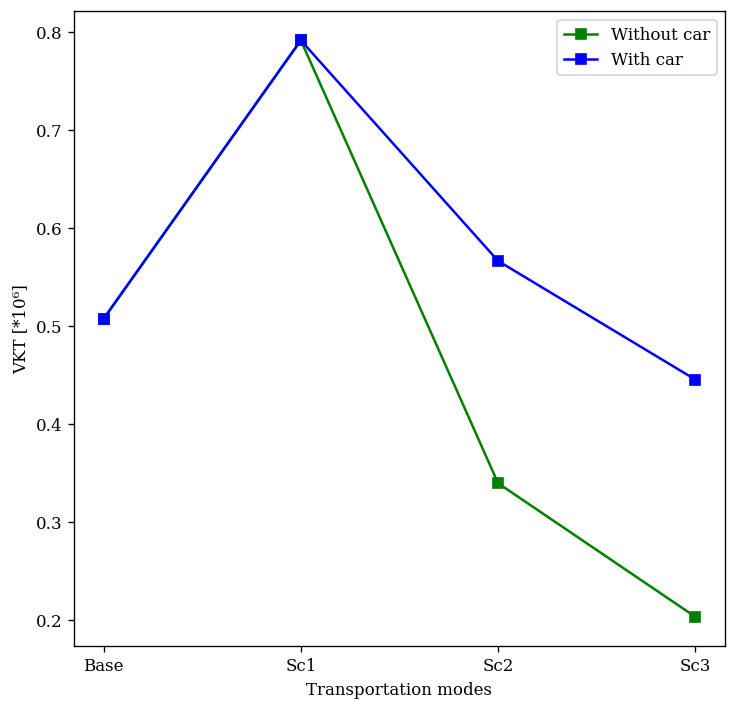

In [218]:
## Source code : https://sites.google.com/view/aide-python/graphiques/les-graphiques-courbes-et-nuages-de-points-scatter-plot

plt.figure(figsize = (7, 7), dpi = 120)

plt.plot(['Base', 'Sc1', 'Sc2', 'Sc3'],[507271.93/10**6, 791961/10**6,  339283.33/10**6, 202747.62/10**6],"-gs", label = "Without car") # green carré

plt.plot(['Base', 'Sc1', 'Sc2', 'Sc3'],[507271.93/10**6, (791961)/10**6, (227165.78 +339283.33)/10**6, (242458.7 + 202747.62)/10**6],"-bs" , label = "With car") # blue carré

plt.legend(loc="upper right")

plt.ylabel('VKT [*10⁶]')

plt.xlabel('Transportation modes')

plt.show()

In [219]:
## Faire uen function ?
vkt_sc1_base = (791961 - 507271.93)/507271.93 * 100
vkt_sc2_base = (227165.78 +339283.33 - 507271.93)/507271.93 * 100
vkt_sc3_base = (242458.7 + 202747.62 - 507271.93)/507271.93 * 100

avg_dist_vh_sc1_base = (43.09 - 18.64)/18.64 * 100
avg_dist_vh_sc2_base = (14.92 + 177.08 - 18.64)/18.64 * 100
avg_dist_vh_sc3_base = (15.25 + 126.56 - 18.64)/18.64 * 100

avg_dist_trip_sc1_base = (7.63 - 5.64)/5.64 * 100
avg_dist_trip_sc2_base = (3.90 + 6.46 - 5.64)/5.64 * 100
avg_dist_trip_sc3_base = (3.74 + 7.7 - 5.64)/5.64 * 100

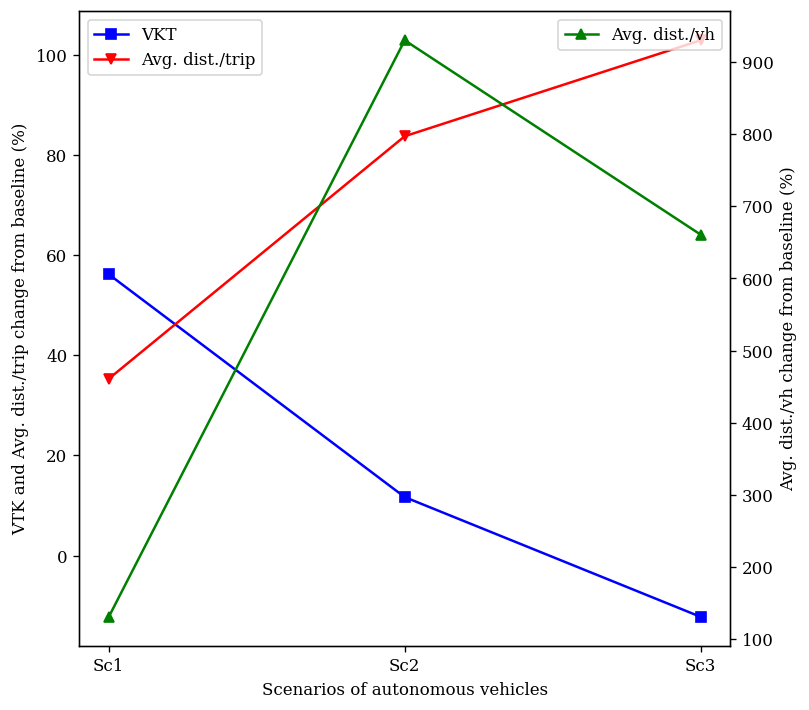

In [220]:
#plt.figure(figsize = (7, 7), dpi = 120)

#plt.plot(['Sc1', 'Sc2', 'Sc3'],[(791961 - 507271.93)/507271.93,  (339283.33 - 507271.93)/507271.93, (202747.62 - 507271.93)/507271.93],"-gs", label = "Without car") # green carré


fig, ax1 = plt.subplots(figsize = (7, 7), dpi = 120)

ax1.set_xlabel('Scenarios of autonomous vehicles')
ax1.set_ylabel('VTK and Avg. dist./trip change from baseline (%)')

ax2 = ax1.twinx()

ax1.plot(['Sc1', 'Sc2', 'Sc3'],[vkt_sc1_base, vkt_sc2_base, vkt_sc3_base],"-bs" , label = "VKT") # blue carré
ax1.plot(['Sc1', 'Sc2', 'Sc3'],[avg_dist_trip_sc1_base, avg_dist_trip_sc2_base, avg_dist_trip_sc3_base],"-vr" , label = "Avg. dist./trip")
ax1.legend(loc="upper left")

ax2.plot(['Sc1', 'Sc2', 'Sc3'],[avg_dist_vh_sc1_base, avg_dist_vh_sc2_base, avg_dist_vh_sc3_base],"-^g", label = "Avg. dist./vh")

ax2.set_ylabel('Avg. dist./vh change from baseline (%)')

ax2.legend(loc="upper right")

#plt.show()
fig.savefig('%s/graphes/vkt_variation_lyon.png' %output_results, bbox_inches="tight")

In [221]:
edt_sc1 = (df_vkt_sce1.loc[1]["total_vkt"] - PKT_trips_sce1_PAV) / df_vkt_sce1.loc[1]["total_vkt"]  * 100
edt_sc2 = (df_vkt_sce2.loc[4]["total_vkt"] - PKT_trips_sce2_taxi) / df_vkt_sce2.loc[4]["total_vkt"]  * 100
edt_sc3 = df_drt_vh_stats.loc[len(df_drt_vh_stats) - 1]["totalEmptyDistance"] / df_drt_vh_stats.loc[len(df_drt_vh_stats) - 1]["totalDistance"] * 100

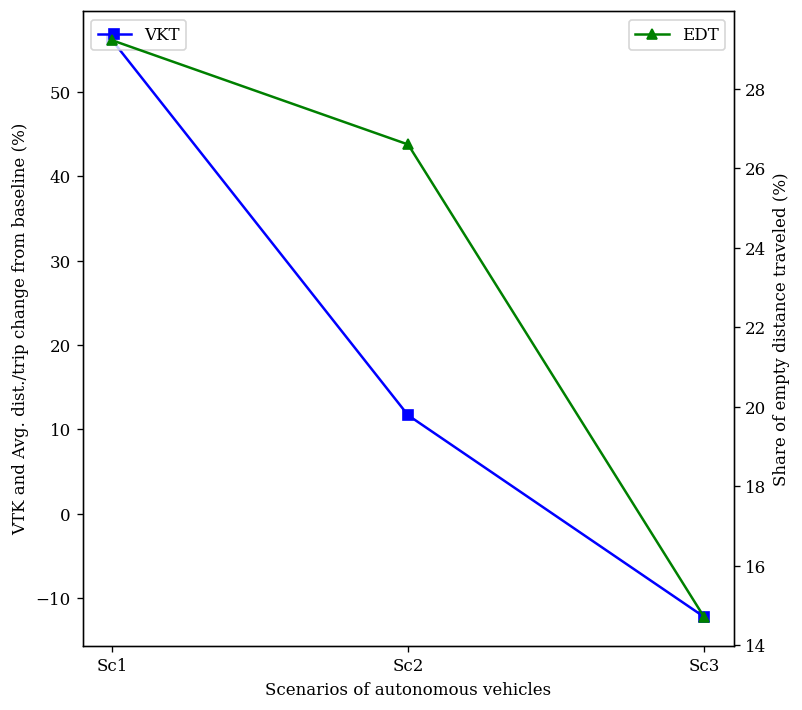

In [222]:
fig, ax1 = plt.subplots(figsize = (7, 7), dpi = 120)

ax1.set_xlabel('Scenarios of autonomous vehicles')
ax1.set_ylabel('VTK and Avg. dist./trip change from baseline (%)')

ax2 = ax1.twinx()

ax1.plot(['Sc1', 'Sc2', 'Sc3'],[vkt_sc1_base, vkt_sc2_base, vkt_sc3_base],"-bs" , label = "VKT") # blue carré
#ax1.plot(['Sc1', 'Sc2', 'Sc3'],[avg_dist_trip_sc1_base, avg_dist_trip_sc2_base, avg_dist_trip_sc3_base],"-vr" , label = "Avg. dist./trip")
ax1.legend(loc="upper left")

ax2.plot(['Sc1', 'Sc2', 'Sc3'],[edt_sc1, edt_sc2, edt_sc3],"-^g", label = "EDT")

ax2.set_ylabel('Share of empty distance traveled (%)')

ax2.legend(loc="upper right")

#plt.show()
fig.savefig('%s/graphes/vkt__edt_variation_lyon.pdf' %output_results, bbox_inches="tight")

## Temps de parcours ( Vehicle-time traveled (VTT))

In [223]:
#df_trips_output_base["dep_time_in_s"] = df_trips_output_base["dep_time"].apply(convert_time_h_m_s).astype(float)
#df_trips_output_base["trav_time_in_s"] = df_trips_output_base["trav_time"].apply(convert_time_h_m_s).astype(float)
#df_trips_output_base["wait_time_in_s"] = df_trips_output_base["wait_time"].apply(convert_time_h_m_s).astype(float)

In [224]:
vtt_base = df_trips_output_base.groupby(["mode_base"])["trav_time_in_s"].sum().reset_index(name = "VTT")

In [225]:
vtt_base

,mode_base,VTT
0,bike,2756591.0
1,car,71530323.0
2,car_passenger,11894535.0
3,pt,74545598.0
4,walk,52943589.0


In [226]:
#df_trips_output_base["dep_time_in_s"] = df_trips_output_base["dep_time"].apply(convert_time_h_m_s).astype(float)
#df_trips_output_base["trav_time_in_s"] = df_trips_output_base["trav_time"].apply(convert_time_h_m_s).astype(float)
#df_trips_output_base["wait_time_in_s"] = df_trips_output_base["wait_time"].apply(convert_time_h_m_s).astype(float)

In [227]:
#vtt_base = df_trips_output_base.groupby(["mode_base"])["trav_time_in_s"].sum().reset_index(name = "VTT")

In [228]:
vtt_base["vtt_m"] = vtt_base["VTT"]/60
vtt_base["vtt_h"] = vtt_base["VTT"]/3600

In [229]:
vtt_base

,mode_base,VTT,vtt_m,vtt_h
0,bike,2756591.0,4.594318e+04,765.719722
1,car,71530323.0,1.192172e+06,19869.534167
2,car_passenger,11894535.0,1.982422e+05,3304.037500
3,pt,74545598.0,1.242427e+06,20707.110556
4,walk,52943589.0,8.823932e+05,14706.552500


In [230]:
df_trips_output_sc1["dep_time_in_s"] = df_trips_output_sc1["dep_time"].apply(convert_time_h_m_s).astype(float)
df_trips_output_sc1["trav_time_in_s"] = df_trips_output_sc1["trav_time"].apply(convert_time_h_m_s).astype(float)
df_trips_output_sc1["wait_time_in_s"] = df_trips_output_sc1["wait_time"].apply(convert_time_h_m_s).astype(float)

In [231]:
vtt_sc1 = df_trips_output_sc1.groupby(["mode_sc1"])["trav_time_in_s"].sum().reset_index(name = "VTT")

In [232]:
vtt_sc1["vtt_m"] = vtt_sc1["VTT"]/60
vtt_sc1["vtt_h"] = vtt_sc1["VTT"]/3600

In [233]:
vtt_sc1

,mode_sc1,VTT,vtt_m,vtt_h
0,bike,716285.0,1.193808e+04,198.968056
1,pav,152068215.0,2.534470e+06,42241.170833
2,pt,107991063.0,1.799851e+06,29997.517500
3,walk,35474252.0,5.912375e+05,9853.958889


In [234]:
df_trips_output_sc2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231001 entries, 0 to 231000
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   person                  231001 non-null  int64  
 1   trip_number             231001 non-null  int64  
 2   trip_id                 231001 non-null  object 
 3   dep_time                231001 non-null  object 
 4   trav_time               231001 non-null  object 
 5   wait_time               231001 non-null  object 
 6   traveled_distance       231001 non-null  int64  
 7   euclidean_distance      231001 non-null  int64  
 8   main_mode               0 non-null       float64
 9   longest_distance_mode   231001 non-null  object 
 10  modes                   231001 non-null  object 
 11  start_activity_type     231001 non-null  object 
 12  end_activity_type       231001 non-null  object 
 13  start_facility_id       231001 non-null  object 
 14  start_link          

In [235]:
vtt_sc2 = df_trips_output_sc2.groupby(["mode_sc2"])["trav_time_in_s"].sum().reset_index(name = "VTT")

In [236]:
vtt_sc2["vtt_m"] = vtt_sc2["VTT"]/60
vtt_sc2["vtt_h"] = vtt_sc2["VTT"]/3600

In [237]:
vtt_sc2

,mode_sc2,VTT,vtt_m,vtt_h
0,bike,508113.0,8.468550e+03,141.142500
1,car,32938551.0,5.489758e+05,9149.597500
2,car_passenger,4616941.0,7.694902e+04,1282.483611
3,pt,110689507.0,1.844825e+06,30747.085278
4,sav,73606794.0,1.226780e+06,20446.331667
5,walk,25130061.0,4.188343e+05,6980.572500


In [238]:
vtt_sc3 = df_trips_output_sc3.groupby(["mode_sc3"])["trav_time_in_s"].sum().reset_index(name = "VTT")

In [239]:
vtt_sc3["vtt_m"] = vtt_sc3["VTT"]/60
vtt_sc3["vtt_h"] = vtt_sc3["VTT"]/3600

In [240]:
vtt_sc3

,mode_sc3,VTT,vtt_m,vtt_h
0,bike,500250.0,8.337500e+03,138.958333
1,car,35702842.0,5.950474e+05,9917.456111
2,car_passenger,4585825.0,7.643042e+04,1273.840278
3,psav,72246120.0,1.204102e+06,20068.366667
4,pt,116705131.0,1.945086e+06,32418.091944
5,walk,26147282.0,4.357880e+05,7263.133889


In [241]:
vtt_base.loc[1]["vtt_h"], vtt_sc1.loc[1]["vtt_h"], vtt_sc2.loc[4]["vtt_h"], vtt_sc3.loc[3]["vtt_h"]

(19869.534166666668, 42241.17083333333, 20446.331666666665, 20068.366666666665)

**VTT (h)**

Modes | Tous | car | car_passenger| pt | pav | sav | psav | bike | walk  
 :--- | :---: | :---: | :---: | :---:  |  :---: |  :---: |  :---: |  :---: |  :---:
**Base**    | $59386.77$ | $19869.53$ | $3287.16$ | $20710.41$ | $-$ | $-$ | $-$ | $750.0$ | $14749.08$
**Sce1**    | $82291.60$ | $-$ | $-$ | $29997.51$ | $42241.17$ | $-$ | $-$ | $198.97$ | $9853.96$
**Sce2**    | $\mathbf{68154.19}$ | $8751.44$ | $1154.29$ | $30177.23$ | $-$ | $19553.26$ | $-$ | $141.90$ | $8376.07$
**Sce3**    | $72525.74$ | $9513.78$ | $1153.23$ | $31651.40$ | $-$ | $-$ | $19656.7875$ | $145.80$ | $8937.66$

In [242]:
##Nombre d'heure d'utilisation des vehicules par jour

In [243]:
# Pourcentage d'utilisation moyenne d'un VP par jour
vtt_base.loc[1]["vtt_h"]/27165/24 * 100

3.047661538540197

In [244]:
# Nombre moyen d'heure d'utilisation d'un VP par jour
vtt_base.loc[1]["vtt_h"]/27165

0.7314387692496472

In [245]:
# Pourcentage d'utilisation moyenne d'un PAV par jour
vtt_sc1.loc[1]["vtt_h"]/18378/24 * 100

9.576933206672228

In [246]:
# Nombre moyen d'heure d'utilisation d'un PAV par jour
vtt_sc1.loc[1]["vtt_h"]/18378

2.2984639696013347

In [247]:
# Pourcentage d'utilisation moyenne d'un taxi par jour 
# Taille flotte : 1916
# Taille flotte utilisée : 1916
vtt_sc2.loc[4]["vtt_h"]/1916/24 * 100

44.46401284504755

In [248]:
# Nombre moyen d'heure d'utilisation d'un taxi par jour
vtt_sc2.loc[4]["vtt_h"]/1916

10.671363082811412

In [249]:
# Pourcentage d'utilisation moyenne d'un drt par jour
# Taille flotte : 1916
# Taille flotte utilisée : 1602
vtt_sc3.loc[3]["vtt_h"]/1602/24 * 100

52.19612636981551

In [250]:
# Nombre moyen d'heure d'utilisation d'un drt par jour
vtt_sc3.loc[3]["vtt_h"]/1602

12.527070328755721

In [251]:
df_trips_global

,person,trip_id,mode_base,dep_time_in_s_base,trav_time_in_s_base,wait_time_in_s_base,mode_sc1,dep_time_in_s_sc1,trav_time_in_s_sc1,wait_time_in_s_sc1,mode_sc2,dep_time_in_s_sc2,trav_time_in_s_sc2,wait_time_in_s_sc2,mode_sc3,dep_time_in_s_sc3,trav_time_in_s_sc3,wait_time_in_s_sc3,person_id
0,1000008,1000008_1,car,25427.0,1175.0,0.0,pav,25152.0,747.0,19.0,pt,25427.0,1464.0,309.0,pt,25427.0,1464.0,309.0,1000008
1,1000008,1000008_2,car,26602.0,869.0,0.0,pav,26302.0,811.0,9.0,pt,26891.0,1795.0,112.0,pt,26891.0,1795.0,112.0,1000008
2,1000008,1000008_3,walk,43427.0,616.0,0.0,walk,43582.0,616.0,0.0,walk,43427.0,616.0,0.0,walk,43427.0,616.0,0.0,1000008
3,1000008,1000008_4,walk,45227.0,616.0,0.0,walk,44995.0,616.0,0.0,walk,45227.0,616.0,0.0,walk,45227.0,616.0,0.0,1000008
4,1000008,1000008_5,car,63227.0,2429.0,0.0,pav,62554.0,6797.0,3855.0,pt,63227.0,2938.0,850.0,pt,63227.0,2938.0,841.0,1000008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229618,999994,999994_1,car,24331.0,1151.0,0.0,pav,24331.0,1521.0,501.0,car,24096.0,1246.0,0.0,car,24443.0,1065.0,0.0,999994
229619,999994,999994_2,car,25531.0,333.0,0.0,pav,25852.0,350.0,9.0,car,25342.0,375.0,0.0,car,26024.0,205.0,0.0,999994
229620,999994,999994_3,car,58531.0,1113.0,0.0,pav,58531.0,4019.0,1365.0,car,60019.0,1731.0,0.0,car,62195.0,1206.0,0.0,999994
229621,999995,999995_1,car,26017.0,785.0,0.0,pav,26017.0,2104.0,1522.0,car,25158.0,565.0,0.0,car,27202.0,523.0,0.0,999995


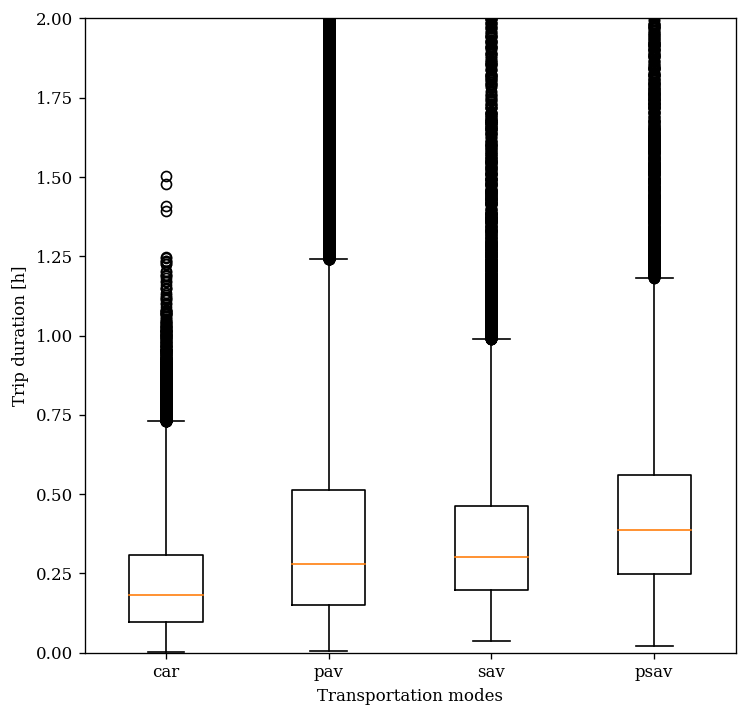

In [252]:
## Ref. code : https://moonbooks.org/Articles/Tracer-une-bo%C3%AEte-%C3%A0-moustaches-avec-matplotlib/

import pylab

data_01 = df_trips_global[df_trips_global["mode_base"] == "car"]["trav_time_in_s_base"].values
data_02 = df_trips_global[df_trips_global["mode_sc1"] == "pav"]["trav_time_in_s_sc1"].values
data_03 = df_trips_global[df_trips_global["mode_sc2"] == "sav"]["trav_time_in_s_sc2"].values
data_04 = df_trips_global[df_trips_global["mode_sc3"] == "psav"]["trav_time_in_s_sc3"].values

data_01 = data_01 / 3600
data_02 = data_02 / 3600
data_03 = data_03 / 3600
data_04 = data_04 / 3600


BoxName = ['car','pav','sav', 'psav']

data = [data_01,data_02,data_03,data_04]

plt.figure(figsize = (7, 7), dpi = 120)

plt.boxplot(data, whis = 2)

plt.ylim([0.0, 2])

pylab.xticks([1,2,3,4], BoxName)

plt.xlabel("Transportation modes")
plt.ylabel("Trip duration [h]")

#plt.show()

plt.savefig('%s/diag_moustache_base_sc1_sc2_sc3_lyon.pdf' %output_results, bbox_inches="tight")

In [253]:
df_trips_global[df_trips_global["mode_base"] == "car"]["trav_time_in_s_base"].quantile(0.05)/3600

0.03805555555555556

In [254]:
df_trips_global[df_trips_global["mode_base"] == "car"]["trav_time_in_s_base"].quantile(0.25)/3600

0.09666666666666666

In [255]:
df_trips_global[df_trips_global["mode_base"] == "car"]["trav_time_in_s_base"].quantile(0.5)/3600

0.18222222222222223

In [256]:
df_trips_global[df_trips_global["mode_base"] == "car"]["trav_time_in_s_base"].quantile(0.75)/3600

0.30777777777777776

In [257]:
df_trips_global[df_trips_global["mode_base"] == "car"]["trav_time_in_s_base"].quantile(0.95)/3600

0.5327777777777778

In [258]:
df_trips_global[df_trips_global["mode_base"] == "car"]["trav_time_in_s_base"].quantile(0.99)/3600

0.7238888888888889

In [259]:
df_trips_global[df_trips_global["mode_base"] == "car"]["trav_time_in_s_base"].quantile(1)/3600

1.5027777777777778

In [260]:
df_trips_global[df_trips_global["mode_base"] == "car"]["trav_time_in_s_base"].min()

2.0

In [261]:
df_legs_output_base = pd.read_csv(gzip.open("%s/output_legs.csv.gz" %output_base_path,'r'), sep=";")
df_legs_output_sc1 = pd.read_csv(gzip.open("%s/sce1.1000_ite.output_legs.csv.gz" %output_sc1_path,'r'), sep=";")
df_legs_output_sc2 = pd.read_csv(gzip.open("%s/sce2.v2.output_legs.csv.gz" %output_sc2_path,'r'), sep=";")
df_legs_output_sc3 = pd.read_csv(gzip.open("%s/sce3.v2.output_legs.csv.gz" %output_sc3_path,'r'), sep=";")

In [262]:
df_legs_output_base

,person,trip_id,dep_time,trav_time,wait_time,distance,mode,start_link,start_x,start_y,end_link,end_x,end_y,access_stop_id,egress_stop_id,transit_line,transit_route
0,1000008,1000008_1,07:03:47,00:19:35,00:00:00,4528,car,8102,844783.995555,6.519932e+06,50655,842728.100000,6.519167e+06,NaN,NaN,NaN,NaN
1,1000008,1000008_2,07:23:22,00:14:29,00:00:00,9621,car,50655,842728.100000,6.519167e+06,51370,841768.160000,6.511899e+06,NaN,NaN,NaN,NaN
2,1000008,1000008_3,12:03:47,00:10:16,00:00:00,740,walk,51370,841768.160000,6.511899e+06,32552,841455.790000,6.511423e+06,NaN,NaN,NaN,NaN
3,1000008,1000008_4,12:33:47,00:10:16,00:00:00,740,walk,32552,841455.790000,6.511423e+06,51370,841768.160000,6.511899e+06,NaN,NaN,NaN,NaN
4,1000008,1000008_5,17:33:47,00:40:29,00:00:00,12976,car,51370,841768.160000,6.511899e+06,8102,844783.995555,6.519932e+06,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336800,999994,999994_2,07:05:31,00:05:33,00:00:00,1357,car,69858,847968.600000,6.518541e+06,33122,847319.700000,6.519014e+06,NaN,NaN,NaN,NaN
336801,999994,999994_3,16:15:31,00:18:33,00:00:00,15563,car,33122,847319.700000,6.519014e+06,17018,854492.550000,6.521136e+06,NaN,NaN,NaN,NaN
336802,999995,999995_1,07:13:37,00:13:05,00:00:00,3605,car,17018,854492.550000,6.521136e+06,44221,857259.400000,6.521244e+06,NaN,NaN,NaN,NaN
336803,999995,999995_2,11:28:37,00:10:46,00:00:00,3719,car,44221,857259.400000,6.521244e+06,17018,854492.550000,6.521136e+06,NaN,NaN,NaN,NaN


In [263]:
df_legs_output_sc1

,person,trip_id,dep_time,trav_time,wait_time,distance,mode,start_link,start_x,start_y,end_link,end_x,end_y,access_stop_id,egress_stop_id,transit_line,transit_route,vehicle_id
0,1000008,1000008_1,06:59:12,00:12:27,00:00:19,4314,private_AV,8102,844783.995555,6.519932e+06,50655,842728.100000,6.519167e+06,NaN,NaN,NaN,NaN,taxi_474430
1,1000008,1000008_2,07:18:22,00:13:31,00:00:09,9609,private_AV,50655,842728.100000,6.519167e+06,51370,841768.160000,6.511899e+06,NaN,NaN,NaN,NaN,taxi_474430
2,1000008,1000008_3,12:06:22,00:10:16,00:00:00,740,walk,51370,841768.160000,6.511899e+06,32552,841455.790000,6.511423e+06,NaN,NaN,NaN,NaN,NaN
3,1000008,1000008_4,12:29:55,00:10:16,00:00:00,740,walk,32552,841455.790000,6.511423e+06,51370,841768.160000,6.511899e+06,NaN,NaN,NaN,NaN,NaN
4,1000008,1000008_5,17:22:34,01:53:17,01:04:15,12639,private_AV,51370,841768.160000,6.511899e+06,8102,844783.995555,6.519932e+06,NaN,NaN,NaN,NaN,taxi_474430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505311,999994,999994_2,07:10:52,00:05:50,00:00:09,1415,private_AV,69858,847968.600000,6.518541e+06,33122,847319.700000,6.519014e+06,NaN,NaN,NaN,NaN,taxi_474420
505312,999994,999994_3,16:15:31,01:06:59,00:22:45,15235,private_AV,33122,847319.700000,6.519014e+06,17018,854492.550000,6.521136e+06,NaN,NaN,NaN,NaN,taxi_474420
505313,999995,999995_1,07:13:37,00:35:04,00:25:22,3605,private_AV,17018,854492.550000,6.521136e+06,44221,857259.400000,6.521244e+06,NaN,NaN,NaN,NaN,taxi_474420
505314,999995,999995_2,11:28:37,00:09:25,00:00:24,3794,private_AV,44221,857259.400000,6.521244e+06,17018,854492.550000,6.521136e+06,NaN,NaN,NaN,NaN,taxi_474420


In [264]:
df_legs_output_sc2

,person,trip_id,dep_time,trav_time,wait_time,distance,mode,start_link,start_x,start_y,end_link,end_x,end_y,access_stop_id,egress_stop_id,transit_line,transit_route,vehicle_id
0,1000008,1000008_1,07:03:47,00:01:59,00:00:00,141,walk,8102,844783.995555,6.519932e+06,pt_32123,844706.805219,6.520009e+06,NaN,NaN,NaN,NaN,NaN
1,1000008,1000008_1,07:05:46,00:13:10,00:05:09,1798,pt,pt_32123,844706.805219,6.520009e+06,pt_32113,843199.444945,6.519366e+06,32123.link:pt_32123,32113.link:pt_32113,T1Ar27,T1A_27_2_060AM_081006,veh_16635_tram
2,1000008,1000008_1,07:18:56,00:09:15,00:00:00,664,walk,pt_32113,843199.444945,6.519366e+06,50655,842728.100000,6.519167e+06,NaN,NaN,NaN,NaN,NaN
3,1000008,1000008_2,07:28:11,00:04:58,00:00:00,356,walk,50655,842728.100000,6.519167e+06,11588,842495.805391,6.519021e+06,NaN,NaN,NaN,NaN,NaN
4,1000008,1000008_2,07:33:09,00:20:34,00:01:52,8241,pt,11588,842495.805391,6.519021e+06,51396,841824.280034,6.511663e+06,166.link:11588,30528.link:51396,15Fa6,15F_6_1_013AM_022012,veh_729_bus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472024,999994,999994_2,07:02:22,00:06:15,00:00:00,1470,car,69858,847968.600000,6.518541e+06,33122,847319.700000,6.519014e+06,NaN,NaN,NaN,NaN,999994
472025,999994,999994_3,16:40:19,00:28:51,00:00:00,11044,car,33122,847319.700000,6.519014e+06,17018,854492.550000,6.521136e+06,NaN,NaN,NaN,NaN,999994
472026,999995,999995_1,06:59:18,00:09:25,00:00:00,3605,car,17018,854492.550000,6.521136e+06,44221,857259.400000,6.521244e+06,NaN,NaN,NaN,NaN,999995
472027,999995,999995_2,10:42:27,00:07:56,00:00:00,3719,car,44221,857259.400000,6.521244e+06,17018,854492.550000,6.521136e+06,NaN,NaN,NaN,NaN,999995


In [265]:
df_legs_output_sc3

,person,trip_id,dep_time,trav_time,wait_time,distance,mode,start_link,start_x,start_y,end_link,end_x,end_y,access_stop_id,egress_stop_id,transit_line,transit_route,vehicle_id
0,1000008,1000008_1,07:03:47,00:01:59,00:00:00,141,walk,8102,844783.995555,6.519932e+06,pt_32123,844706.805219,6.520009e+06,NaN,NaN,NaN,NaN,NaN
1,1000008,1000008_1,07:05:46,00:13:10,00:05:09,1798,pt,pt_32123,844706.805219,6.520009e+06,pt_32113,843199.444945,6.519366e+06,32123.link:pt_32123,32113.link:pt_32113,T1Ar27,T1A_27_2_060AM_081006,veh_16635_tram
2,1000008,1000008_1,07:18:56,00:09:15,00:00:00,664,walk,pt_32113,843199.444945,6.519366e+06,50655,842728.100000,6.519167e+06,NaN,NaN,NaN,NaN,NaN
3,1000008,1000008_2,07:28:11,00:04:58,00:00:00,356,walk,50655,842728.100000,6.519167e+06,11588,842495.805391,6.519021e+06,NaN,NaN,NaN,NaN,NaN
4,1000008,1000008_2,07:33:09,00:20:34,00:01:52,8241,pt,11588,842495.805391,6.519021e+06,51396,841824.280034,6.511663e+06,166.link:11588,30528.link:51396,15Fa6,15F_6_1_013AM_022012,veh_729_bus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499777,999994,999994_2,07:13:44,00:03:25,00:00:00,1470,car,69858,847968.600000,6.518541e+06,33122,847319.700000,6.519014e+06,NaN,NaN,NaN,NaN,999994
499778,999994,999994_3,17:16:35,00:20:06,00:00:00,11044,car,33122,847319.700000,6.519014e+06,17018,854492.550000,6.521136e+06,NaN,NaN,NaN,NaN,999994
499779,999995,999995_1,07:33:22,00:08:43,00:00:00,3655,car,17018,854492.550000,6.521136e+06,44221,857259.400000,6.521244e+06,NaN,NaN,NaN,NaN,999995
499780,999995,999995_2,11:38:27,00:09:36,00:00:00,3719,car,44221,857259.400000,6.521244e+06,17018,854492.550000,6.521136e+06,NaN,NaN,NaN,NaN,999995


In [266]:
df_legs_output_base["dep_time_in_s"] = df_legs_output_base["dep_time"].apply(convert_time_h_m_s).astype(float)
df_legs_output_base["trav_time_in_s"] = df_legs_output_base["trav_time"].apply(convert_time_h_m_s).astype(float)
df_legs_output_base["wait_time_in_s"] = df_legs_output_base["wait_time"].apply(convert_time_h_m_s).astype(float)
df_legs_output_sc1["dep_time_in_s"] = df_legs_output_sc1["dep_time"].apply(convert_time_h_m_s).astype(float)
df_legs_output_sc1["trav_time_in_s"] = df_legs_output_sc1["trav_time"].apply(convert_time_h_m_s).astype(float)
df_legs_output_sc1["wait_time_in_s"] = df_legs_output_sc1["wait_time"].apply(convert_time_h_m_s).astype(float)
df_legs_output_sc2["dep_time_in_s"] = df_legs_output_sc2["dep_time"].apply(convert_time_h_m_s).astype(float)
df_legs_output_sc2["trav_time_in_s"] = df_legs_output_sc2["trav_time"].apply(convert_time_h_m_s).astype(float)
df_legs_output_sc2["wait_time_in_s"] = df_legs_output_sc2["wait_time"].apply(convert_time_h_m_s).astype(float)
df_legs_output_sc3["dep_time_in_s"] = df_legs_output_sc3["dep_time"].apply(convert_time_h_m_s).astype(float)
df_legs_output_sc3["trav_time_in_s"] = df_legs_output_sc3["trav_time"].apply(convert_time_h_m_s).astype(float)
df_legs_output_sc3["wait_time_in_s"] = df_legs_output_sc3["wait_time"].apply(convert_time_h_m_s).astype(float)

In [267]:
#base_car_legs = df_legs_output_base[df_legs_output_base["mode"] =="car"].groupby(["vehicle_id"])["trav_time_in_s"].sum().reset_index(name = "VTT")
##Assumption person_id = car_id
base_car_legs = df_legs_output_base[df_legs_output_base["mode"] =="car"].groupby(["person"])["trav_time_in_s"].sum().reset_index(name = "VTT")
sc1_legs = df_legs_output_sc1[df_legs_output_sc1["mode"] =="private_AV"].groupby(["vehicle_id"])["trav_time_in_s"].sum().reset_index(name = "VTT")
sc2_legs = df_legs_output_sc2[df_legs_output_sc2["mode"] =="taxi"].groupby(["vehicle_id"])["trav_time_in_s"].sum().reset_index(name = "VTT")
sc3_legs = df_legs_output_sc3[df_legs_output_sc3["mode"] =="drt"].groupby(["vehicle_id"])["trav_time_in_s"].sum().reset_index(name = "VTT")

In [268]:
base_car_legs["VTT_h"] = base_car_legs["VTT"] / 3600
sc1_legs["VTT_h"] = sc1_legs["VTT"] / 3600
sc2_legs["VTT_h"] = sc2_legs["VTT"] / 3600
sc3_legs["VTT_h"] = sc3_legs["VTT"] / 3600

In [269]:
base_car_legs

,person,VTT,VTT_h
0,45,794.0,0.220556
1,88,1462.0,0.406111
2,89,847.0,0.235278
3,255,3881.0,1.078056
4,256,477.0,0.132500
...,...,...,...
27557,1231619,444.0,0.123333
27558,1231699,1323.0,0.367500
27559,1231700,1676.0,0.465556
27560,1231725,991.0,0.275278


In [270]:
sc1_legs

,vehicle_id,VTT,VTT_h
0,taxi_100028,269.0,0.074722
1,taxi_100065,28806.0,8.001667
2,taxi_100111,3588.0,0.996667
3,taxi_100137,2085.0,0.579167
4,taxi_100161,3799.0,1.055278
...,...,...,...
18373,taxi_99801,36056.0,10.015556
18374,taxi_99827,1655.0,0.459722
18375,taxi_99838,8128.0,2.257778
18376,taxi_99896,15900.0,4.416667


In [271]:
sc2_legs

,vehicle_id,VTT,VTT_h
0,TAX1001057,37939.0,10.538611
1,TAX1001423,40215.0,11.170833
2,TAX1001641,35032.0,9.731111
3,TAX1001658,46042.0,12.789444
4,TAX1001734,35256.0,9.793333
...,...,...,...
1911,TAXVIL111879,42201.0,11.722500
1912,TAXVIL11282,41082.0,11.411667
1913,TAXVIL11470,35012.0,9.725556
1914,TAXVIL1182,34922.0,9.700556


In [272]:
sc3_legs

,vehicle_id,VTT,VTT_h
0,TAX1001057,52347.0,14.540833
1,TAX1001423,30961.0,8.600278
2,TAX1001641,31447.0,8.735278
3,TAX1001658,54967.0,15.268611
4,TAX1001734,57869.0,16.074722
...,...,...,...
1597,TAXVIL111879,43506.0,12.085000
1598,TAXVIL11282,46529.0,12.924722
1599,TAXVIL11470,52462.0,14.572778
1600,TAXVIL1182,39589.0,10.996944


In [273]:
base_car_legs['VTT_h'].mean(), base_car_legs['VTT_h'].median(),  base_car_legs['VTT_h'].std()

(0.7241289033209993, 0.6413888888888889, 0.476837131702622)

In [274]:
sc1_legs['VTT_h'].mean(), sc1_legs['VTT_h'].median(), sc1_legs['VTT_h'].std()

(2.165198319851025, 1.3084722222222223, 2.47208394022037)

In [275]:
sc2_legs['VTT_h'].mean(), sc2_legs['VTT_h'].median(), sc2_legs['VTT_h'].std()

(9.901035722570183, 9.920555555555556, 1.251612023744774)

In [276]:
sc3_legs['VTT_h'].mean(), sc3_legs['VTT_h'].median(), sc3_legs['VTT_h'].std()

(11.320876855319746, 11.309027777777779, 3.6975330647394977)

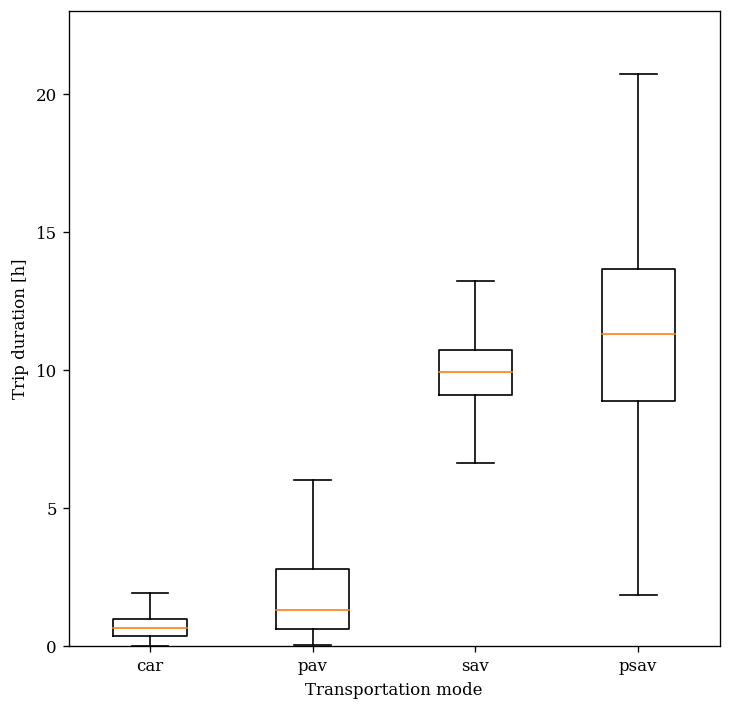

In [277]:
import pylab

data_car = base_car_legs["VTT_h"].values
data_pav = sc1_legs["VTT_h"].values
data_taxi = sc2_legs["VTT_h"].values
data_drt = sc3_legs["VTT_h"].values

BoxName = ['car', 'pav','sav', 'psav']

data = [data_car,data_pav,data_taxi,data_drt]

plt.figure(figsize = (7, 7), dpi = 120)

plt.boxplot(data, whis = 1.5, showfliers=False)

plt.ylim([0.0, 23])

pylab.xticks([1,2,3,4], BoxName)

plt.xlabel("Transportation mode")
plt.ylabel("Trip duration [h]")

#plt.show()

plt.savefig('%s/diag_moustache_base_sc1_sc2_sc3_lyon_legs.pdf' %output_results, bbox_inches="tight")

In [ ]:
#Remark Mathile : Pas juste le calcul pour le DRT (scenario 3) en se basant sur les déplacements. 
#Car les passagenrs partagent le meme taxi en meme temps !!!!
#Donc prise en compte du task time profiles

In [289]:
task_time_profiles_drt_file = "%s/ITERS/it.2000/sce3.v2.2000.task_time_profiles_drt.txt" %output_sc3_path
df_task_time_profiles_drt = pd.read_csv(task_time_profiles_drt_file, sep="	")

In [290]:
df_task_time_profiles_drt

,time,STAY,DRIVE,STOP
0,00:00,1916.0,0.0,0.0
1,00:05,1916.0,0.0,0.0
2,00:10,1916.0,0.0,0.0
3,00:15,1916.0,0.0,0.0
4,00:20,1916.0,0.0,0.0
...,...,...,...,...
356,29:40,1916.0,0.0,0.0
357,29:45,1916.0,0.0,0.0
358,29:50,1916.0,0.0,0.0
359,29:55,1916.0,0.0,0.0


In [291]:
df_task_time_profiles_drt["time_in_s"] = df_task_time_profiles_drt["time"].apply(convert_time).astype(float)

In [293]:
soum_drt_driving_30h = df_task_time_profiles_drt["DRIVE"].sum()

In [306]:
#Average time using drt 
soum_drt_driving_30h/len(sc3_legs)

72.09436537661256

In [304]:
#Average time using drt : Les intervalles de temps sont de 5min. Donc, il ne faut pas diviser par 24. 
soum_drt_driving_30h/24/len(sc3_legs)

3.00393189069219

In [305]:
#Average time using drt : Les intervalles de temps sont de 5min. Donc, il faut les convertir en heure! 5/60 = 1/12 
soum_drt_driving_30h/12/len(sc3_legs)

6.00786378138438

### Number of trip per vh

In [278]:
nb_request_vh_bse = df_legs_output_base[df_legs_output_base["mode"] =="car"].groupby(["person"])["person"].count().reset_index(name = "nb_request")
nb_request_vh_sc1 = df_legs_output_sc1[df_legs_output_sc1["mode"] =="private_AV"].groupby(["vehicle_id"])["person"].count().reset_index(name = "nb_request")
nb_request_vh_sc2 = df_legs_output_sc2[df_legs_output_sc2["mode"] =="taxi"].groupby(["vehicle_id"])["person"].count().reset_index(name = "nb_request")
nb_request_vh_sc3 = df_legs_output_sc3[df_legs_output_sc3["mode"] =="drt"].groupby(["vehicle_id"])["person"].count().reset_index(name = "nb_request")

In [279]:
nb_request_vh_bse['nb_request'].mean(), nb_request_vh_bse['nb_request'].median(),  nb_request_vh_bse['nb_request'].std()

(3.358319425295697, 3.0, 1.7260097089724704)

In [280]:
nb_request_vh_sc1['nb_request'].mean(), nb_request_vh_sc1['nb_request'].median(),  nb_request_vh_sc1['nb_request'].std()

(5.652736968114049, 5.0, 3.7456965372826647)

In [281]:
nb_request_vh_sc2['nb_request'].mean(), nb_request_vh_sc2['nb_request'].median(),  nb_request_vh_sc2['nb_request'].std()

(27.424843423799583, 28.0, 6.456691529778942)

In [282]:
nb_request_vh_sc3['nb_request'].mean(), nb_request_vh_sc3['nb_request'].median(),  nb_request_vh_sc3['nb_request'].std()

(27.534332084893883, 27.0, 10.427364294525724)

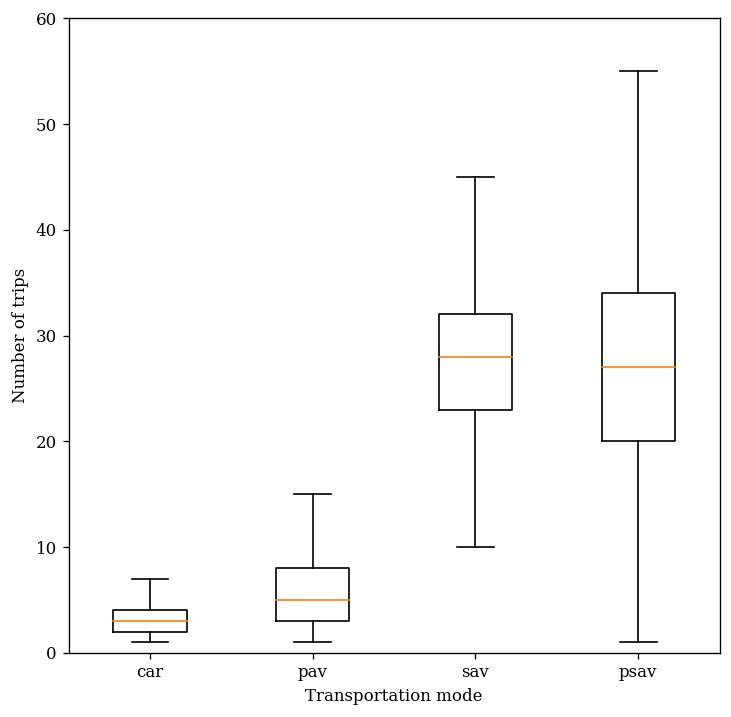

In [286]:
import pylab

data_car = nb_request_vh_bse["nb_request"].values
data_pav = nb_request_vh_sc1["nb_request"].values
data_taxi = nb_request_vh_sc2["nb_request"].values
data_drt = nb_request_vh_sc3["nb_request"].values

BoxName = ['car', 'pav','sav', 'psav']

data = [data_car,data_pav,data_taxi,data_drt]

plt.figure(figsize = (7, 7), dpi = 120)

plt.boxplot(data, whis = 1.5, showfliers=False)

plt.ylim([0.0, 60])

pylab.xticks([1,2,3,4], BoxName)

plt.xlabel("Transportation mode")
plt.ylabel("Number of trips")

#plt.show()

plt.savefig('%s/diag_moustache_base_sc1_sc2_sc3_lyon_nb_trips_vh.pdf' %output_results, bbox_inches="tight")

### Taux d'occupation des taxis

In [372]:
### PAV
occupancy_time_profiles_pav_file = "%s/ITERS/it.1300/sce1.1000_ite.1300.occupancy_time_profiles_private_AV.txt" %output_sc1_path
df_occupancy_time_profiles_pav = pd.read_csv(occupancy_time_profiles_pav_file, sep="	")

In [373]:
df_occupancy_time_profiles_pav["time_in_s"] = df_occupancy_time_profiles_pav["time"].apply(convert_time).astype(float)

In [374]:
df_occupancy_time_profiles_pav["occ_rate"] = (0 * df_occupancy_time_profiles_pav["0 pax"] + 1* df_occupancy_time_profiles_pav["1 pax"] + 2 * df_occupancy_time_profiles_pav["2 pax"] + 3 * df_occupancy_time_profiles_pav["3 pax"] + 4* df_occupancy_time_profiles_pav["4 pax"]) 

In [375]:
df_occupancy_time_profiles_pav["occ_rate"] /= (df_occupancy_time_profiles_pav["0 pax"] + df_occupancy_time_profiles_pav["1 pax"] + df_occupancy_time_profiles_pav["2 pax"] + df_occupancy_time_profiles_pav["3 pax"] + df_occupancy_time_profiles_pav["4 pax"])  

In [376]:
df_occupancy_time_profiles_pav["occ_rate"] = df_occupancy_time_profiles_pav["occ_rate"].replace({np.nan:0})

In [377]:
df_occupancy_time_profiles_pav["occ_rate"].describe()

count    361.000000
mean       0.544063
std        0.352699
min        0.000000
25%        0.000000
50%        0.702526
75%        0.745243
max        1.000000
Name: occ_rate, dtype: float64

In [397]:
df_occupancy_time_profiles_pav

,time,STAY,0 pax,1 pax,2 pax,3 pax,4 pax,time_in_s,occ_rate
0,00:00,20510.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00:05,20510.0,0.0,0.0,0.0,0.0,0.0,300.0,0.0
2,00:10,20510.0,0.0,0.0,0.0,0.0,0.0,600.0,0.0
3,00:15,20510.0,0.0,0.0,0.0,0.0,0.0,900.0,0.0
4,00:20,20510.0,0.0,0.0,0.0,0.0,0.0,1200.0,0.0
...,...,...,...,...,...,...,...,...,...
356,29:40,0.0,0.0,0.0,0.0,0.0,0.0,106800.0,0.0
357,29:45,0.0,0.0,0.0,0.0,0.0,0.0,107100.0,0.0
358,29:50,0.0,0.0,0.0,0.0,0.0,0.0,107400.0,0.0
359,29:55,0.0,0.0,0.0,0.0,0.0,0.0,107700.0,0.0


In [396]:
df_occupancy_time_profiles_pav["1 pax"].describe()

count     361.000000
mean      806.224737
std       917.649771
min         0.000000
25%         0.000000
50%       368.950000
75%      1204.226667
max      3083.283333
Name: 1 pax, dtype: float64

In [410]:
##Temps total d'utilisation à vide par jour
empty_driv_pav_30h = df_occupancy_time_profiles_pav["0 pax"].sum()
print("Temps total d'utilisation à vide par jour PAV" , empty_driv_pav_30h/12)
print("Temps total d'utilisation à vide par jour par vehicule PAV" , empty_driv_pav_30h/12/nb_pav_sc1)

Temps total d'utilisation à vide par jour PAV 10039.689722222223
Temps total d'utilisation à vide par jour par vehicule PAV 0.5462884820014269


In [411]:
nb_pav_sc1

18378

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


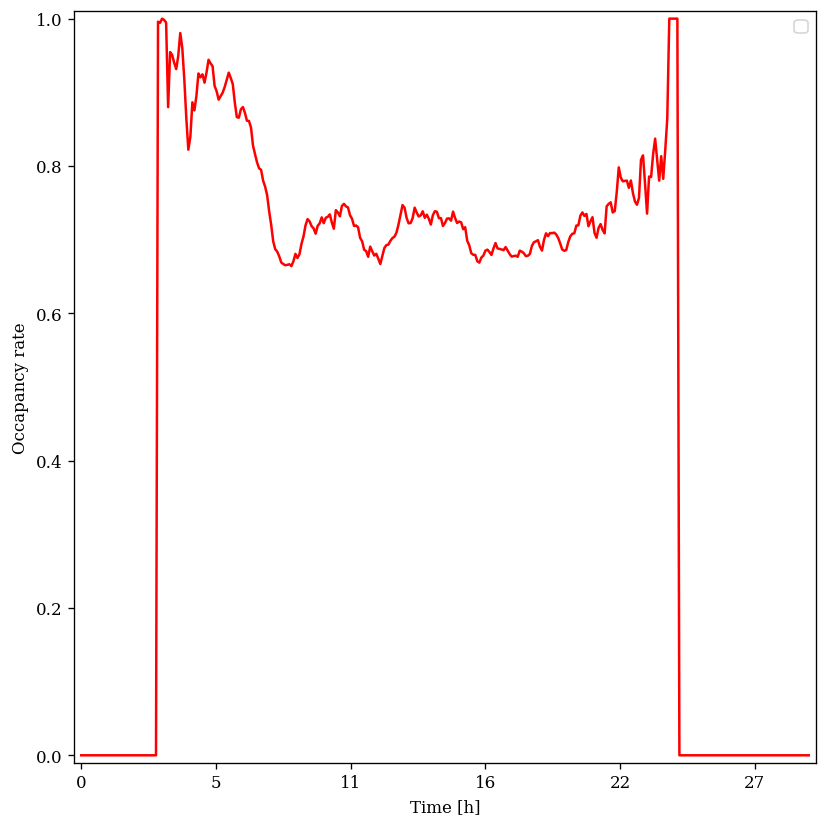

In [379]:
plt.figure(figsize = (7, 7), dpi = 120)


plt.plot(df_occupancy_time_profiles_pav["time_in_s"], df_occupancy_time_profiles_pav["occ_rate"], color = "red")#, label = "Occupancy rate")#, linestyle = ":")



plt.xlabel("Time [h]")
plt.ylabel("Occapancy rate")

plt.gca().xaxis.set_major_formatter(tck.FuncFormatter(
        lambda x, k: "%d" % (x/3600)
))

#plt.grid()
plt.gca().set_axisbelow(True)
#plt.xlim([6000, 90000])
plt.legend(loc = "best")
plt.margins(x=0.01)
plt.margins(y=0.01)
plt.tight_layout()
plt.show()
#plt.savefig('%s/occupancy_rate_pav.pdf' %output_results, bbox_inches="tight")
plt.close()

In [380]:
df_occupancy_time_profiles_pav[df_occupancy_time_profiles_pav["time_in_s"] < 23*3600 + 1]["occ_rate"].describe()

count    277.000000
mean       0.650466
std        0.272024
min        0.000000
25%        0.680820
50%        0.718245
75%        0.747343
max        1.000000
Name: occ_rate, dtype: float64

In [381]:
### SAV
occupancy_time_profiles_sav_file = "%s/ITERS/it.2000/sce2.v2.2000.occupancy_time_profiles_taxi.txt" %output_sc2_path
df_occupancy_time_profiles_sav = pd.read_csv(occupancy_time_profiles_sav_file, sep="	")

In [382]:
df_occupancy_time_profiles_sav["time_in_s"] = df_occupancy_time_profiles_sav["time"].apply(convert_time).astype(float)

In [384]:
df_occupancy_time_profiles_sav["occ_rate"] = (0 * df_occupancy_time_profiles_sav["0 pax"] + 1* df_occupancy_time_profiles_sav["1 pax"]) 

In [385]:
df_occupancy_time_profiles_sav["occ_rate"] /= (df_occupancy_time_profiles_sav["0 pax"] + df_occupancy_time_profiles_sav["1 pax"])  

In [386]:
df_occupancy_time_profiles_sav["occ_rate"] = df_occupancy_time_profiles_sav["occ_rate"].replace({np.nan:0})

In [387]:
df_occupancy_time_profiles_sav["occ_rate"].describe()

count    361.000000
mean       0.618235
std        0.307186
min        0.000000
25%        0.514842
50%        0.762067
75%        0.827878
max        1.000000
Name: occ_rate, dtype: float64

In [388]:
df_occupancy_time_profiles_sav

,time,STAY,0 pax,1 pax,time_in_s,occ_rate
0,00:00,1916.0,0.0,0.0,0.0,0.0
1,00:05,1916.0,0.0,0.0,300.0,0.0
2,00:10,1916.0,0.0,0.0,600.0,0.0
3,00:15,1916.0,0.0,0.0,900.0,0.0
4,00:20,1916.0,0.0,0.0,1200.0,0.0
...,...,...,...,...,...,...
356,29:40,1916.0,0.0,0.0,106800.0,0.0
357,29:45,1916.0,0.0,0.0,107100.0,0.0
358,29:50,1916.0,0.0,0.0,107400.0,0.0
359,29:55,1916.0,0.0,0.0,107700.0,0.0


In [408]:
##Temps total d'utilisation à vide par jour
empty_driv_sav_30h = df_occupancy_time_profiles_sav["0 pax"].sum()

print("Temps total d'utilisation à vide par jour SAV" , empty_driv_sav_30h/12)
print("Temps total d'utilisation à vide par jour par vehicule SAV" , empty_driv_sav_30h/12/nb_sav_sc2)

Temps total d'utilisation à vide par jour SAV 6267.425833333334
Temps total d'utilisation à vide par jour par vehicule SAV 3.2710990779401534


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


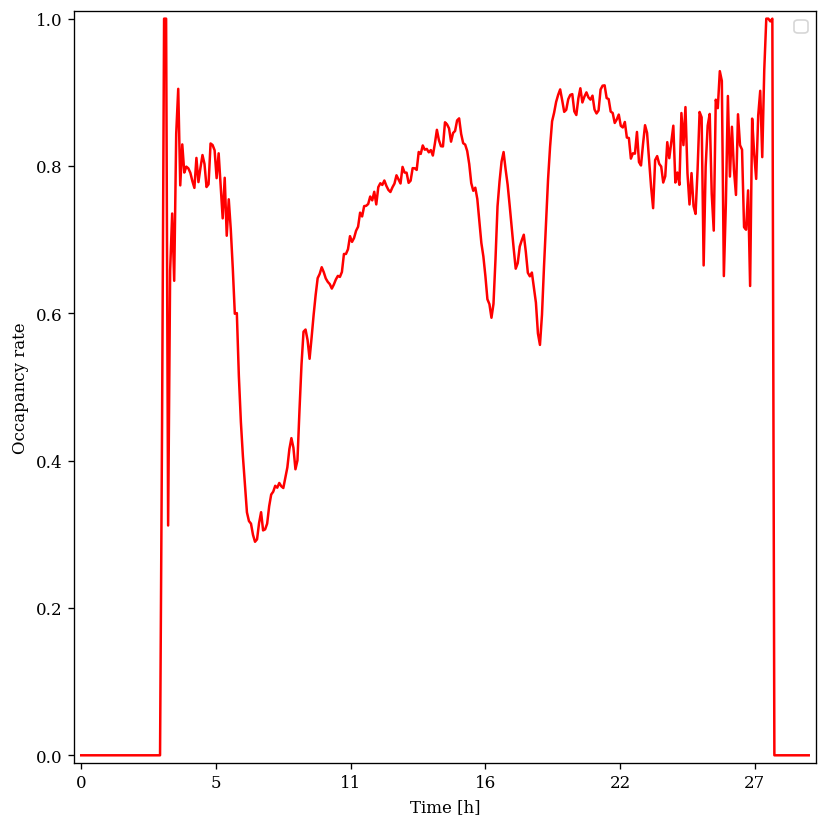

In [390]:
plt.figure(figsize = (7, 7), dpi = 120)


plt.plot(df_occupancy_time_profiles_sav["time_in_s"], df_occupancy_time_profiles_sav["occ_rate"], color = "red")#, label = "Occupancy rate")#, linestyle = ":")



plt.xlabel("Time [h]")
plt.ylabel("Occapancy rate")

plt.gca().xaxis.set_major_formatter(tck.FuncFormatter(
        lambda x, k: "%d" % (x/3600)
))

#plt.grid()
plt.gca().set_axisbelow(True)
#plt.xlim([6000, 90000])
plt.legend(loc = "best")
plt.margins(x=0.01)
plt.margins(y=0.01)
plt.tight_layout()
plt.show()
#plt.savefig('%s/occupancy_rate_sav.pdf' %output_results, bbox_inches="tight")
plt.close()

In [391]:
df_occupancy_time_profiles_sav[df_occupancy_time_profiles_sav["time_in_s"] < 23*3600 + 1]["occ_rate"].describe()

count    277.000000
mean       0.610298
std        0.294868
min        0.000000
25%        0.450000
50%        0.735454
75%        0.820286
max        1.000000
Name: occ_rate, dtype: float64

In [363]:
### PSAV
occupancy_time_profiles_drt_file = "%s/ITERS/it.2000/sce3.v2.2000.occupancy_time_profiles_drt.txt" %output_sc3_path
df_occupancy_time_profiles_drt = pd.read_csv(occupancy_time_profiles_drt_file, sep="	")

In [364]:
df_occupancy_time_profiles_drt["time_in_s"] = df_occupancy_time_profiles_drt["time"].apply(convert_time).astype(float)

In [365]:
df_occupancy_time_profiles_drt["occ_rate"] = (0 * df_occupancy_time_profiles_drt["0 pax"] + 1* df_occupancy_time_profiles_drt["1 pax"] + 2 * df_occupancy_time_profiles_drt["2 pax"] + 3 * df_occupancy_time_profiles_drt["3 pax"] + 4* df_occupancy_time_profiles_drt["4 pax"]) 

In [366]:
df_occupancy_time_profiles_drt["occ_rate"] /= (df_occupancy_time_profiles_drt["0 pax"] + df_occupancy_time_profiles_drt["1 pax"] + df_occupancy_time_profiles_drt["2 pax"] + df_occupancy_time_profiles_drt["3 pax"] + df_occupancy_time_profiles_drt["4 pax"])  

In [367]:
df_occupancy_time_profiles_drt["occ_rate"] = df_occupancy_time_profiles_drt["occ_rate"].replace({np.nan:0})

In [368]:
df_occupancy_time_profiles_drt["occ_rate"].describe()

count    361.000000
mean       1.013436
std        0.526564
min        0.000000
25%        0.739342
50%        1.200340
75%        1.467324
max        1.580855
Name: occ_rate, dtype: float64

In [369]:
df_occupancy_time_profiles_drt

,time,STAY,0 pax,1 pax,2 pax,3 pax,4 pax,time_in_s,occ_rate
0,00:00,1916.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00:05,1916.0,0.0,0.0,0.0,0.0,0.0,300.0,0.0
2,00:10,1916.0,0.0,0.0,0.0,0.0,0.0,600.0,0.0
3,00:15,1916.0,0.0,0.0,0.0,0.0,0.0,900.0,0.0
4,00:20,1916.0,0.0,0.0,0.0,0.0,0.0,1200.0,0.0
...,...,...,...,...,...,...,...,...,...
356,29:40,1916.0,0.0,0.0,0.0,0.0,0.0,106800.0,0.0
357,29:45,1916.0,0.0,0.0,0.0,0.0,0.0,107100.0,0.0
358,29:50,1916.0,0.0,0.0,0.0,0.0,0.0,107400.0,0.0
359,29:55,1916.0,0.0,0.0,0.0,0.0,0.0,107700.0,0.0


In [409]:
##Temps total d'utilisation à vide par jour
empty_driv_psav_30h = df_occupancy_time_profiles_drt["0 pax"].sum()
print("Temps total d'utilisation à vide par jour PSAV" , empty_driv_psav_30h/12)
print("Temps total d'utilisation à vide par jour par vehicule PSAV" , empty_driv_psav_30h/12/nb_sav_sc2)

Temps total d'utilisation à vide par jour PSAV 2468.683888888889
Temps total d'utilisation à vide par jour par vehicule PSAV 1.288457144514034


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


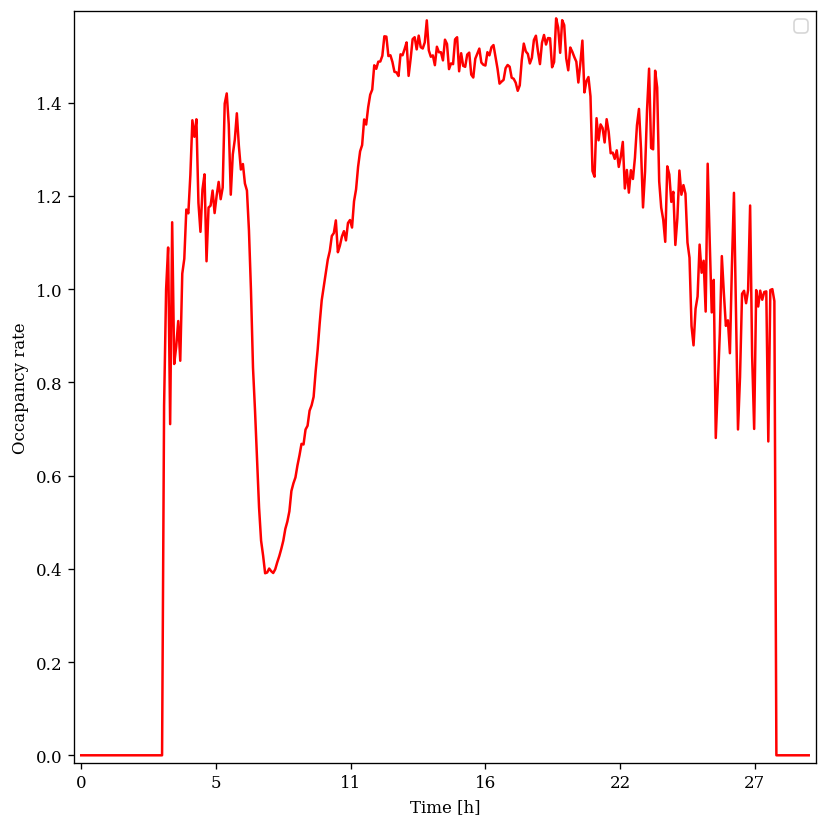

In [370]:
plt.figure(figsize = (7, 7), dpi = 120)


plt.plot(df_occupancy_time_profiles_drt["time_in_s"], df_occupancy_time_profiles_drt["occ_rate"], color = "red")#, label = "Occupancy rate")#, linestyle = ":")



plt.xlabel("Time [h]")
plt.ylabel("Occapancy rate")

plt.gca().xaxis.set_major_formatter(tck.FuncFormatter(
        lambda x, k: "%d" % (x/3600)
))

#plt.grid()
plt.gca().set_axisbelow(True)
#plt.xlim([6000, 90000])
plt.legend(loc = "best")
plt.margins(x=0.01)
plt.margins(y=0.01)
plt.tight_layout()
plt.show()
#plt.savefig('%s/occupancy_rate_psav.pdf' %output_results, bbox_inches="tight")
plt.close()

In [371]:
df_occupancy_time_profiles_drt[df_occupancy_time_profiles_drt["time_in_s"] < 23*3600 + 1]["occ_rate"].describe()

count    277.000000
mean       1.063297
std        0.536080
min        0.000000
25%        0.739342
50%        1.284010
75%        1.484702
max        1.580855
Name: occ_rate, dtype: float64

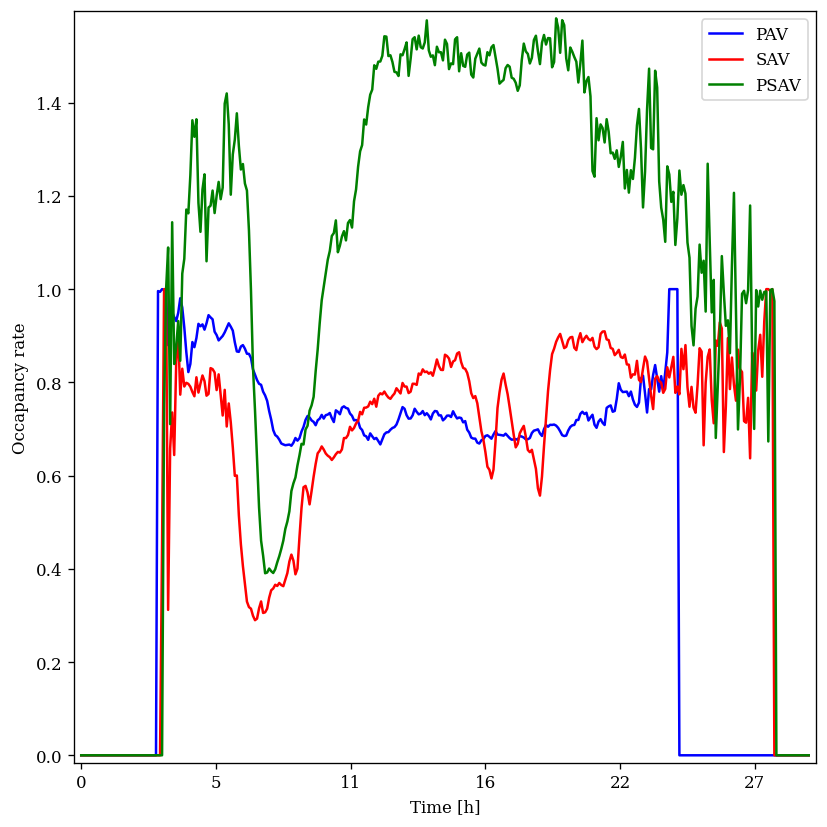

In [395]:
###Global

plt.figure(figsize = (7, 7), dpi = 120)


plt.plot(df_occupancy_time_profiles_pav["time_in_s"], df_occupancy_time_profiles_pav["occ_rate"], color = "blue", label = "PAV")#, linestyle = ":")
plt.plot(df_occupancy_time_profiles_sav["time_in_s"], df_occupancy_time_profiles_sav["occ_rate"], color = "red", label = "SAV")#, linestyle = ":")
plt.plot(df_occupancy_time_profiles_drt["time_in_s"], df_occupancy_time_profiles_drt["occ_rate"], color = "green", label = "PSAV")#, linestyle = ":")



plt.xlabel("Time [h]")
plt.ylabel("Occapancy rate")

plt.gca().xaxis.set_major_formatter(tck.FuncFormatter(
        lambda x, k: "%d" % (x/3600)
))

#plt.grid()
plt.gca().set_axisbelow(True)
#plt.xlim([6000, 90000])
plt.legend(loc = "best")
plt.margins(x=0.01)
plt.margins(y=0.01)
plt.tight_layout()
plt.show()
#plt.savefig('%s/occupancy_rate_pav_sav_psav.pdf' %output_results, bbox_inches="tight")
plt.close()

To do :

- Distribution des zones d'activités des DRT